# Data Collection and Exploration

In [ ]:
# Mengimpor modul drive untuk berinteraksi dengan file di drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

# Tentukan path dataset di Google Drive
dataset_path = "/content/drive/MyDrive/Data/GarbageClassification.zip"

# Mengekstrak dataset
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
  zip_ref.extractall("/content")



In [ ]:
import os

# Cek apakah file sudah diekstraksi dengan benar
os.listdir("/content/garbage_classification")

['green-glass',
 'shoes',
 'plastic',
 'white-glass',
 'metal',
 'paper',
 'brown-glass',
 'cardboard',
 'clothes',
 'biological',
 'trash',
 'battery']

## Impor Library

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import cv2
import random
from collections import Counter
import glob
import math
from tqdm import tqdm
import warnings
from sklearn.cluster import KMeans
warnings.filterwarnings("ignore")

Mengatur konfigurasi plot

In [ ]:
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (12, 8)

## Eksplorasi Struktur Dataset

In [ ]:
data_dir = "/content/garbage_classification"

In [ ]:
def explore_dataset_structure(base_dir):
  """Mengeksplorasi struktur folder dataset"""
  print("Struktur Dataset: ")
  classes = os.listdir(base_dir)
  classes = [c for c in classes if os.path.isdir(os.path.join(base_dir,c))]

  class_counts = {}
  total_images = 0

  print(f"Jumlah kelas: {len(classes)}")
  print("Nama kelas: ")

  for cls in classes:
    class_path = os.path.join(base_dir, cls)
    num_images = len(os.listdir(class_path))
    class_counts[cls] = num_images
    total_images += num_images
    print(f" - {cls} : {num_images} gambar")

  print(f"Total gambar: {total_images}")
  return classes, class_counts, total_images

In [ ]:
classes, class_counts, total_images = explore_dataset_structure(data_dir)

Struktur Dataset: 
Jumlah kelas: 12
Nama kelas: 
 - green-glass : 629 gambar
 - shoes : 1977 gambar
 - plastic : 865 gambar
 - white-glass : 775 gambar
 - metal : 769 gambar
 - paper : 1050 gambar
 - brown-glass : 607 gambar
 - cardboard : 891 gambar
 - clothes : 5325 gambar
 - biological : 985 gambar
 - trash : 697 gambar
 - battery : 945 gambar
Total gambar: 15515


## Augmentasi Data 

In [ ]:
import os
import shutil
import random
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt # Untuk visualisasi jika diperlukan nanti

# --- Konfigurasi Augmentasi Gambar ---
# Anda dapat menyesuaikan parameter augmentasi ini sesuai kebutuhan.
image_datagen = ImageDataGenerator(
    rotation_range=30,        # Derajat rotasi acak
    width_shift_range=0.15,   # Geser lebar secara acak (fraksi dari total lebar)
    height_shift_range=0.15,  # Geser tinggi secara acak (fraksi dari total tinggi)
    shear_range=0.15,         # Intensitas shear (geser sudut)
    zoom_range=0.15,          # Rentang zoom acak
    horizontal_flip=True,     # Balik horizontal secara acak
    fill_mode='nearest'       # Metode pengisian piksel baru yang mungkin muncul
)

# --- Fungsi Helper untuk Mendapatkan Jumlah Sampel per Kelas ---
def get_class_counts(base_dir):
    """Menghitung jumlah file (gambar) dalam setiap subdirektori (kelas) di base_dir."""
    class_counts = {}
    if not os.path.exists(base_dir):
        print(f"Error: Directory {base_dir} tidak ditemukan.")
        return class_counts

    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            # Pastikan hanya menghitung file, bukan subdirektori lain di dalam folder kelas
            num_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = num_files
    return class_counts

# --- Fungsi 1: Upsampling Kelas Minoritas ---
def upsample_minority_classes(base_dir, save_dir, target_count=None):
    """
    Melakukan augmentasi pada kelas minoritas untuk mencapai target_count.
    Jika target_count tidak ditentukan, defaultnya adalah rata-rata jumlah sampel per kelas.
    Semua gambar asli juga disalin ke save_dir.

    Args:
        base_dir (str): Path ke direktori dataset asli.
        save_dir (str): Path ke direktori untuk menyimpan dataset yang telah diproses.
        target_count (int, optional): Jumlah sampel target untuk kelas minoritas setelah augmentasi.
                                      Jika None, menggunakan rata-rata sampel per kelas.
    """
    if os.path.exists(save_dir):
        print(f"Direktori {save_dir} sudah ada. Menghapus direktori lama.")
        shutil.rmtree(save_dir)
    os.makedirs(save_dir, exist_ok=True)
    print(f"Direktori {save_dir} berhasil dibuat/dibersihkan.")

    class_counts = get_class_counts(base_dir)
    if not class_counts:
        print(f"Tidak ada kelas yang ditemukan di {base_dir}. Proses dihentikan.")
        return

    print(f"Jumlah sampel asli per kelas: {class_counts}")

    effective_target_count = target_count
    if effective_target_count is None:
        if class_counts: # Pastikan class_counts tidak kosong
            total_samples = sum(class_counts.values())
            num_classes = len(class_counts)
            effective_target_count = int(total_samples / num_classes) if num_classes > 0 else 0
            print(f"Target jumlah sampel untuk upsampling (rata-rata): {effective_target_count}")
        else:
            effective_target_count = 0 # Tidak ada target jika tidak ada kelas
            print("Tidak ada kelas untuk menghitung rata-rata, target upsampling adalah 0.")
    else:
        print(f"Target jumlah sampel untuk upsampling (user-defined): {effective_target_count}")

    if effective_target_count == 0 :
        print("Peringatan: Target jumlah sampel untuk upsampling adalah 0. Tidak ada augmentasi yang akan dilakukan, hanya penyalinan file asli.")


    for class_name, current_samples in class_counts.items():
        class_original_path = os.path.join(base_dir, class_name)
        class_save_path = os.path.join(save_dir, class_name)
        os.makedirs(class_save_path, exist_ok=True)

        image_files = [f for f in os.listdir(class_original_path) if os.path.isfile(os.path.join(class_original_path, f))]

        # 1. Salin semua gambar asli
        for img_file in image_files:
            shutil.copy(os.path.join(class_original_path, img_file), os.path.join(class_save_path, img_file))

        # 2. Lakukan augmentasi jika diperlukan
        if current_samples < effective_target_count and image_files: # Hanya augmentasi jika kurang dari target dan ada gambar asli
            num_to_augment = effective_target_count - current_samples
            print(f"Kelas '{class_name}': Memiliki {current_samples} gambar. Perlu augmentasi {num_to_augment} gambar untuk mencapai {effective_target_count}.")

            augmented_count = 0
            # Loop untuk menghasilkan jumlah gambar augmentasi yang dibutuhkan
            while augmented_count < num_to_augment:
                # Pilih gambar acak dari daftar gambar asli untuk diaugmentasi
                random_image_file = random.choice(image_files)
                img_path = os.path.join(class_original_path, random_image_file)

                try:
                    img = load_img(img_path)  # Muat gambar
                    x = img_to_array(img)     # Ubah ke numpy array
                    x = x.reshape((1,) + x.shape)  # Reshape ke (1, height, width, channels)

                    # Hasilkan satu gambar augmentasi dan simpan
                    # Awalan unik untuk setiap gambar augmentasi baru
                    save_prefix = f'aug_{class_name}_{current_samples + augmented_count}'

                    # Menggunakan iterator dari .flow() dan mengambil satu batch
                    flow_iterator = image_datagen.flow(x, batch_size=1,
                                                       save_to_dir=class_save_path,
                                                       save_prefix=save_prefix,
                                                       save_format='jpg')
                    next(flow_iterator) # Ini akan menghasilkan dan menyimpan 1 gambar
                    augmented_count += 1
                except Exception as e:
                    print(f"Error saat augmentasi gambar {img_path}: {e}. Mencoba gambar lain jika ada.")
                    # Jika terjadi error pada satu gambar, loop akan mencoba gambar lain (jika ada)
                    # atau berhenti jika hanya ada satu gambar dan itu error.
                    # Untuk menghindari infinite loop jika semua gambar error, tambahkan mekanisme break:
                    if len(image_files) <= 1 : # Jika hanya ada 1 gambar dan error, atau tidak ada gambar lagi.
                        print(f"Tidak dapat melanjutkan augmentasi untuk kelas {class_name} karena error pada satu-satunya/semua gambar.")
                        break
            print(f"Kelas '{class_name}': {augmented_count} gambar berhasil diaugmentasi.")
        elif not image_files and current_samples < effective_target_count:
             print(f"Kelas '{class_name}': Memiliki {current_samples} gambar (terdaftar) tetapi tidak ada file gambar yang ditemukan di {class_original_path} untuk augmentasi.")
        else:
            print(f"Kelas '{class_name}': Memiliki {current_samples} gambar. Tidak memerlukan upsampling (tidak di bawah target {effective_target_count}).")

    print("\nProses upsampling dan penyalinan selesai.")
    final_counts = get_class_counts(save_dir)
    print(f"Jumlah sampel final per kelas di {save_dir}: {final_counts}")

# --- Fungsi 2: Downsampling Kelas Mayoritas ---
def downsample_majority_classes(base_dir, save_dir, target_count=None,
                                max_samples_factor_vs_average=None,
                                max_samples_factor_vs_second_largest=None):
    """
    Mengurangi jumlah sampel pada kelas mayoritas dan menyalin gambar untuk semua kelas.

    Args:
        base_dir (str): Path ke direktori dataset asli.
        save_dir (str): Path ke direktori untuk menyimpan dataset yang telah diproses.
        target_count (int, optional): Jika ditentukan, kelas dengan sampel > target_count akan
                                      dikurangi menjadi target_count. Ini prioritas utama.
        max_samples_factor_vs_average (float, optional):
            Jika target_count tidak ada, kelas dengan sampel > (avg * faktor ini)
            akan dikurangi ke (avg * faktor ini). Misal: 1.5 atau 2.0.
        max_samples_factor_vs_second_largest (float, optional):
            Jika target_count tidak ada, ini berlaku untuk kelas terbesar.
            Jika sampel kelas terbesar > (sampel kelas ke-2 * faktor ini),
            maka dikurangi ke (sampel kelas ke-2 * faktor ini). Misal: 1.2 atau 1.5.
    """
    if os.path.exists(save_dir):
        print(f"Direktori {save_dir} sudah ada. Menghapus direktori lama.")
        shutil.rmtree(save_dir)
    os.makedirs(save_dir, exist_ok=True)
    print(f"Direktori {save_dir} berhasil dibuat/dibersihkan.")

    class_counts = get_class_counts(base_dir)
    if not class_counts:
        print(f"Tidak ada kelas yang ditemukan di {base_dir}. Proses dihentikan.")
        return

    print(f"Jumlah sampel asli per kelas: {class_counts}")

    # Urutkan kelas berdasarkan jumlah sampel (descending)
    sorted_classes = sorted(class_counts.items(), key=lambda item: item[1], reverse=True)

    avg_samples_per_class = 0
    if class_counts: # Pastikan class_counts tidak kosong
        total_samples = sum(class_counts.values())
        num_classes = len(class_counts)
        avg_samples_per_class = int(total_samples / num_classes) if num_classes > 0 else 0
    print(f"Rata-rata sampel per kelas: {avg_samples_per_class}")

    for class_name, current_samples in class_counts.items():
        class_original_path = os.path.join(base_dir, class_name)
        class_save_path = os.path.join(save_dir, class_name)
        os.makedirs(class_save_path, exist_ok=True)

        image_files = [f for f in os.listdir(class_original_path) if os.path.isfile(os.path.join(class_original_path, f))]

        num_to_keep = current_samples # Default: pertahankan semua gambar

        # Tentukan jumlah gambar yang akan disimpan untuk kelas ini
        if target_count is not None: # Prioritas 1: target absolut dari user
            if current_samples > target_count:
                num_to_keep = target_count
                print(f"Kelas '{class_name}': Memiliki {current_samples} gambar. Menerapkan batas absolut, akan disimpan {num_to_keep} gambar.")
        else: # Tidak ada target absolut, gunakan faktor rasio
            potential_caps = []
            # Cap berdasarkan rata-rata (jika faktornya diberikan)
            if max_samples_factor_vs_average is not None and avg_samples_per_class > 0:
                cap_avg = int(avg_samples_per_class * max_samples_factor_vs_average)
                if current_samples > cap_avg :
                    potential_caps.append(cap_avg)

            # Cap berdasarkan kelas terbesar kedua (jika faktornya diberikan dan ini adalah kelas terbesar)
            if max_samples_factor_vs_second_largest is not None and len(sorted_classes) > 1:
                # Cek apakah kelas saat ini adalah kelas terbesar
                if class_name == sorted_classes[0][0] and current_samples > sorted_classes[1][1]: # Ini kelas terbesar dan > kelas kedua
                    second_largest_count = sorted_classes[1][1]
                    cap_second = int(second_largest_count * max_samples_factor_vs_second_largest)
                    if current_samples > cap_second:
                        potential_caps.append(cap_second)

            if potential_caps: # Jika ada batasan yang berlaku
                num_to_keep = min(current_samples, min(potential_caps)) # Ambil batasan terkecil, tapi tidak lebih dari jumlah asli
                if num_to_keep < current_samples:
                     print(f"Kelas '{class_name}': Memiliki {current_samples} gambar. Menerapkan batas dinamis, akan disimpan {num_to_keep} gambar.")


        if num_to_keep < current_samples: # Jika perlu downsampling
            print(f"Kelas '{class_name}': Downsampling dari {current_samples} ke {num_to_keep} gambar.")
            selected_images = random.sample(image_files, num_to_keep)
            for img_file in selected_images:
                shutil.copy(os.path.join(class_original_path, img_file), os.path.join(class_save_path, img_file))
        else: # Tidak perlu downsampling, salin semua
            print(f"Kelas '{class_name}': Memiliki {current_samples} gambar. Tidak memerlukan downsampling. Menyalin semua gambar.")
            for img_file in image_files:
                shutil.copy(os.path.join(class_original_path, img_file), os.path.join(class_save_path, img_file))

    print("\nProses downsampling dan penyalinan selesai.")
    final_counts = get_class_counts(save_dir)
    print(f"Jumlah sampel final per kelas di {save_dir}: {final_counts}")

### Untuk Downsampling Kelas Mayoritas

In [ ]:
base_dataset_path = '/content/garbage_classification' # Ganti dengan path Anda
downsampled_dataset_path = '/content/garbage_classification_downsampled'

# Opsi 1: Downsample kelas yang > 1.5x rata-rata, menjadi 1.5x rata-rata.
# Dan kelas terbesar tidak lebih dari 1.2x kelas terbesar kedua.
downsample_majority_classes(base_dataset_path, downsampled_dataset_path,
                            max_samples_factor_vs_average=1.5,
                            max_samples_factor_vs_second_largest=1.2)

# Opsi 2: Downsample semua kelas yang memiliki > 600 gambar menjadi 600 gambar.
# downsample_majority_classes(base_dataset_path, downsampled_dataset_path, target_count=600)

Direktori /content/garbage_classification_downsampled berhasil dibuat/dibersihkan.
Jumlah sampel asli per kelas: {'green-glass': 629, 'shoes': 1977, 'plastic': 865, 'white-glass': 775, 'metal': 769, 'paper': 1050, 'brown-glass': 607, 'cardboard': 891, 'clothes': 5325, 'biological': 985, 'trash': 697, 'battery': 945}
Rata-rata sampel per kelas: 1292
Kelas 'green-glass': Memiliki 629 gambar. Tidak memerlukan downsampling. Menyalin semua gambar.
Kelas 'shoes': Memiliki 1977 gambar. Menerapkan batas dinamis, akan disimpan 1938 gambar.
Kelas 'shoes': Downsampling dari 1977 ke 1938 gambar.
Kelas 'plastic': Memiliki 865 gambar. Tidak memerlukan downsampling. Menyalin semua gambar.
Kelas 'white-glass': Memiliki 775 gambar. Tidak memerlukan downsampling. Menyalin semua gambar.
Kelas 'metal': Memiliki 769 gambar. Tidak memerlukan downsampling. Menyalin semua gambar.
Kelas 'paper': Memiliki 1050 gambar. Tidak memerlukan downsampling. Menyalin semua gambar.
Kelas 'brown-glass': Memiliki 607 gambar

### Untuk Upsampling Kelas Minoritas

In [ ]:
base_dataset_path = '/content/garbage_classification_downsampled' # Ganti dengan path Anda
upsampled_dataset_path = '/content/garbage_classification_balanced'

# Opsi 1: Upsample ke rata-rata jumlah sampel per kelas
upsample_minority_classes(base_dataset_path, upsampled_dataset_path)

# Opsi 2: Upsample ke jumlah target tertentu, misal 500 gambar per kelas minoritas
# upsample_minority_classes(base_dataset_path, upsampled_dataset_path, target_count=500)

Direktori /content/garbage_classification_balanced berhasil dibuat/dibersihkan.
Jumlah sampel asli per kelas: {'green-glass': 629, 'shoes': 1938, 'plastic': 865, 'white-glass': 775, 'metal': 769, 'paper': 1050, 'brown-glass': 607, 'cardboard': 891, 'clothes': 1938, 'biological': 985, 'trash': 697, 'battery': 945}
Target jumlah sampel untuk upsampling (rata-rata): 1007
Kelas 'green-glass': Memiliki 629 gambar. Perlu augmentasi 378 gambar untuk mencapai 1007.
Kelas 'green-glass': 378 gambar berhasil diaugmentasi.
Kelas 'shoes': Memiliki 1938 gambar. Tidak memerlukan upsampling (tidak di bawah target 1007).
Kelas 'plastic': Memiliki 865 gambar. Perlu augmentasi 142 gambar untuk mencapai 1007.
Kelas 'plastic': 142 gambar berhasil diaugmentasi.
Kelas 'white-glass': Memiliki 775 gambar. Perlu augmentasi 232 gambar untuk mencapai 1007.
Kelas 'white-glass': 232 gambar berhasil diaugmentasi.
Kelas 'metal': Memiliki 769 gambar. Perlu augmentasi 238 gambar untuk mencapai 1007.
Kelas 'metal': 238 

In [ ]:
classes, class_counts, total_images = explore_dataset_structure('/content/garbage_classification_balanced')

Struktur Dataset: 
Jumlah kelas: 12
Nama kelas: 
 - green-glass : 1007 gambar
 - shoes : 1938 gambar
 - plastic : 1007 gambar
 - white-glass : 1007 gambar
 - metal : 1007 gambar
 - paper : 1050 gambar
 - brown-glass : 1007 gambar
 - cardboard : 1007 gambar
 - clothes : 1938 gambar
 - biological : 1007 gambar
 - trash : 1007 gambar
 - battery : 1007 gambar
Total gambar: 13989


In [ ]:
print(classes)
print(class_counts)
print(total_images)

['metal', 'trash', 'battery', 'green-glass', 'biological', 'plastic', 'white-glass', 'clothes', 'paper', 'brown-glass', 'cardboard', 'shoes']
{'metal': 769, 'trash': 697, 'battery': 945, 'green-glass': 629, 'biological': 985, 'plastic': 865, 'white-glass': 775, 'clothes': 5325, 'paper': 1050, 'brown-glass': 607, 'cardboard': 891, 'shoes': 1977}
15515


## Visualisasi Distribusi Kelas

In [ ]:
def plot_class_distribution(class_counts):
  """ Memvisualisasikan distribusi kelas """
  plt.figure(figsize=(14, 8))

  # Urutkan kelas berdasarkan jumlah gambar
  sorted_counts = {key: value for key, value in sorted(class_counts.items(), key = lambda item: item[1], reverse = True)}

  sns.barplot(x=list(sorted_counts.keys()), y=list(sorted_counts.values()))
  plt.title("Distribusi Kelas dalam Dataset", fontsize = 16)
  plt.xlabel("Kelas", fontsize=14)
  plt.ylabel("Jumlah gambar", fontsize=14)
  plt.xticks(rotation=45, ha="right")
  plt.tight_layout()
  plt.show()

  # Hitung persentase setiap kelas
  total = sum(class_counts.values())
  percentages = {cls: (count / total) for cls, count in class_counts.items()}

  print("Persentase setiap kelas:")
  for cls, percentage in sorted(percentages.items(), key=lambda item: item[1], reverse=True):
    print(f"{cls}: {percentage * 100:.2f}%")


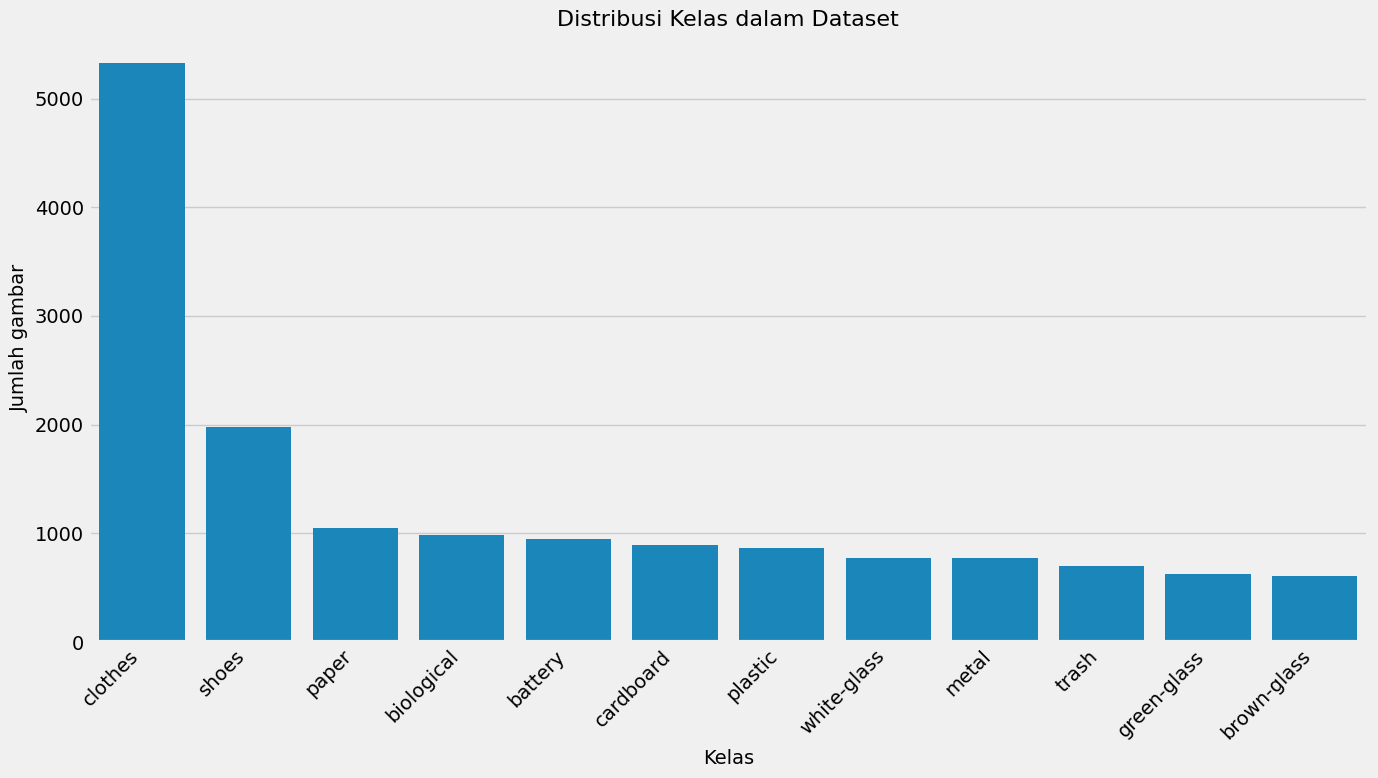

Persentase setiap kelas:
clothes: 34.32%
shoes: 12.74%
paper: 6.77%
biological: 6.35%
battery: 6.09%
cardboard: 5.74%
plastic: 5.58%
white-glass: 5.00%
metal: 4.96%
trash: 4.49%
green-glass: 4.05%
brown-glass: 3.91%


In [ ]:
plot_class_distribution(class_counts)

## Visualisasi Sampel Gambar

In [ ]:
def display_sample_images(base_dir, classes, samples_per_class=3):
  """Menampilkan sampel gambar dari setiap kelas"""
  num_classes = len(classes)
  fig, axes = plt.subplots(nrows=samples_per_class, ncols=num_classes, figsize=(20, 4*samples_per_class))

  for col, cls in enumerate(classes):
    class_path = os.path.join(base_dir, cls)
    images = os.listdir(class_path)

    # Pilih sampel acak
    samples = random.sample(images, min(samples_per_class, len(images)))

    for row, img_name in enumerate(samples):
      img_path = os.path.join(class_path, img_name)
      img = Image.open(img_path)

      #Tampilkan gambar
      axes[row, col].imshow(img)
      axes[row, col].axis("off")

      if row == 0:
        axes[row, col].set_title(cls)

  plt.tight_layout()
  plt.show()

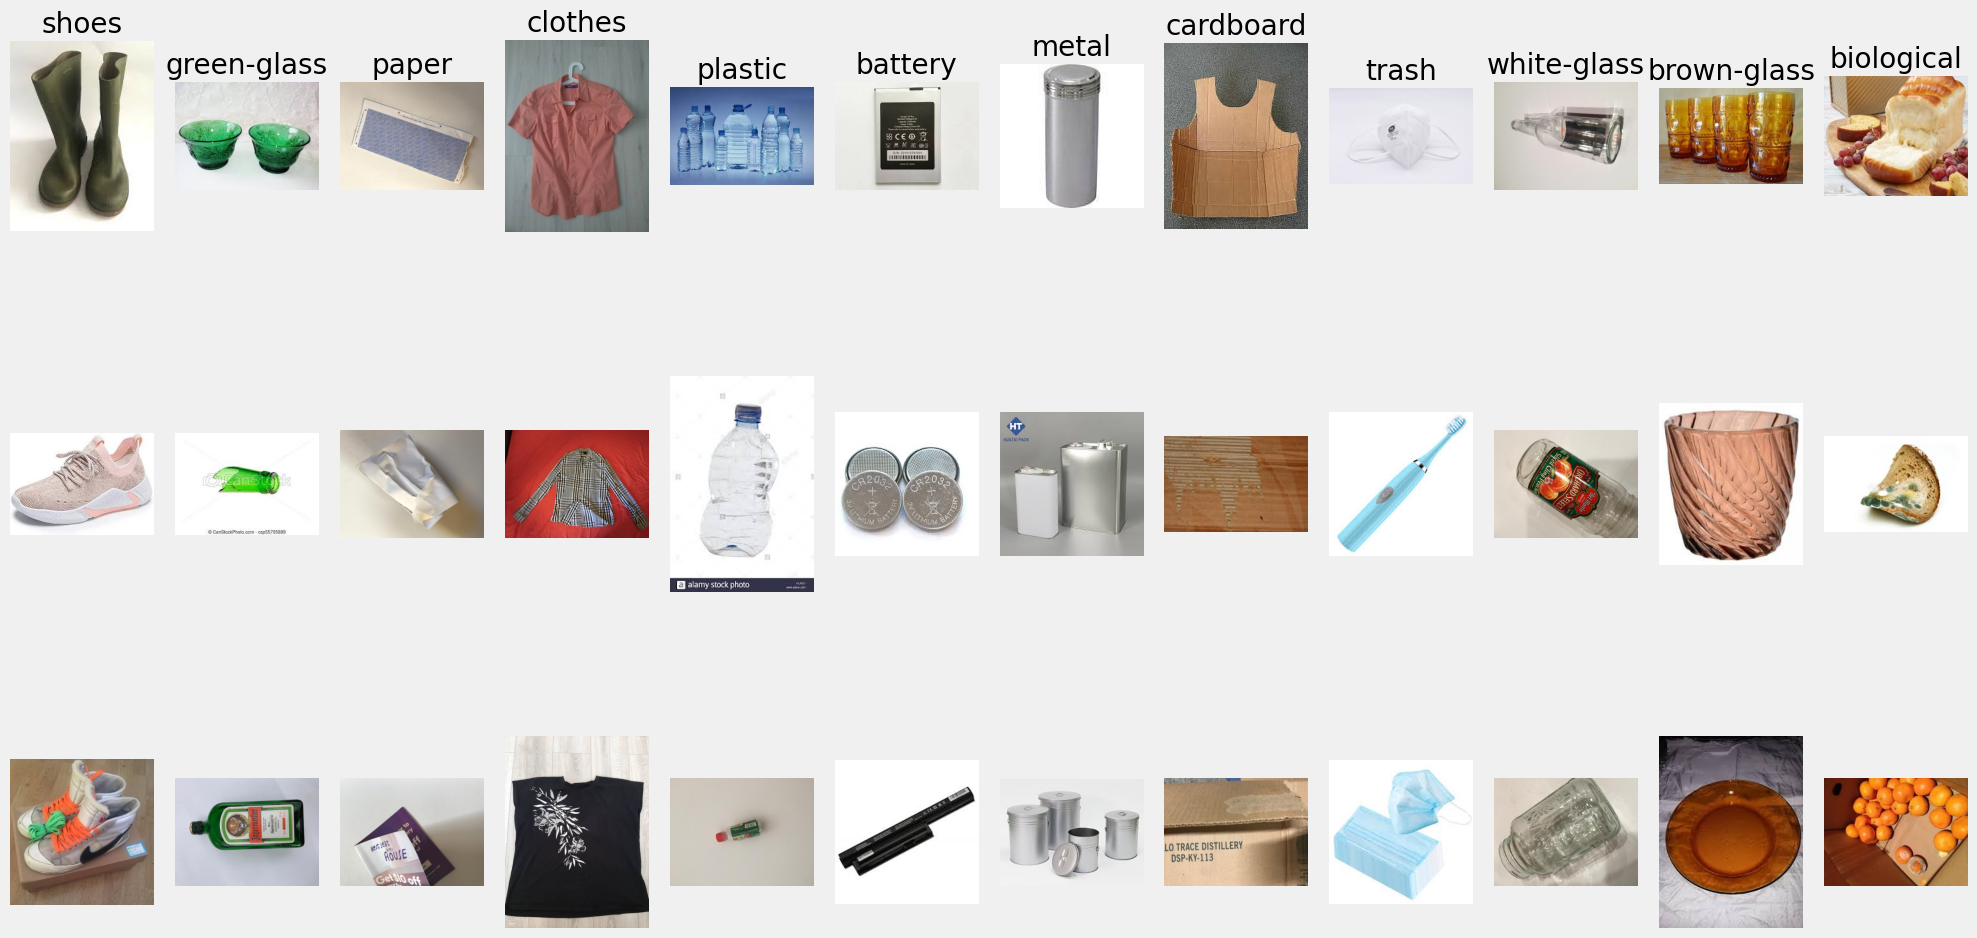

In [ ]:
display_sample_images(data_dir, classes)

## Analisis Dimensi Gambar

In [ ]:
def analyze_image_dimensions(base_dir, classes, sample_size=100):
  """Menganalisis dimensi gambar dalam dataset"""
  widths = []
  heights = []
  aspect_ratios = []
  file_sizes = []

  for cls in classes:
    class_path = os.path.join(base_dir, cls)
    images = os.listdir(class_path)

    # Ambil sampel acak untuk analisis (untuk kecepatan)
    samples = random.sample(images, min(sample_size, len(images)))

    for img_name in samples:
      img_path = os.path.join(class_path, img_name)

      # Dimensi gambar
      img = Image.open(img_path)
      w, h = img.size
      widths.append(w)
      heights.append(h)
      aspect_ratios.append(w/h)

      # Ukuran file
      file_size = os.path.getsize(img_path) / 1024 # KB
      file_sizes.append(file_size)


    # Visualisasi dimensi
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # Histogram lebar
    axes[0, 0].hist(widths, bins=30, color="blue", alpha=0.7)
    axes[0, 0].set_title("Distribusi Lebar Gambar", fontsize=14)
    axes[0, 0].set_xlabel("Lebar (piksel)", fontsize = 12)
    axes[0, 0].set_ylabel("Frekuensi", fontsize = 12)

    # Histogram tinggi
    axes[0, 1].hist(heights, bins = 30, color = "green", alpha = 0.7)
    axes[0, 1].set_title("Distribusi Tinggi Gambar", fontsize = 12)
    axes[0, 1].set_xlabel("Tinggi (piksel)", fontsize = 12)
    axes[0, 1].set_ylabel("Frekuensi", fontsize=12)

    # Histogram aspect ratio
    axes[1, 0].hist(aspect_ratios, bins=30, color="purple", alpha=0.7)
    axes[1, 0].set_title("Distribusi Aspect Ratio (Lebar/Tinggi)", fontsize=12)
    axes[1, 0].set_xlabel("Aspect Ratio", fontsize=12)
    axes[1, 0].set_ylabel("Frekuensi", fontsize=12)

    # Histogram ukuran file
    axes[1, 1].hist(file_sizes, bins=30, color="orange", alpha=0.7)
    axes[1, 1].set_title("Distribusi Ukuran File", fontsize = 14)
    axes[1, 1].set_xlabel("Ukuran File (KB)", fontsize = 12)
    axes[1, 1].set_ylabel("Frekuensi", fontsize = 12)

    plt.tight_layout()
    plt.show()

    # Statistik dimensi
    print(f"Lebar gambar - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.2f}, Median: {np.median(widths)}")
    print(f"Tinggi gambar - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.2f}, Median: {np.median(heights)}")
    print(f"Aspect ration - Min: {min(aspect_ratios):.2f}, Max: {max(aspect_ratios):.2f}, Mean: {np.mean(aspect_ratios):.2f}")
    print(f"Ukuran file (KB) - Min: {min(file_sizes):.2f}, Max: {max(file_sizes):.2f}, Mean: {np.mean(file_sizes):.2f}")

    return widths, heights, aspect_ratios, file_sizes




Analisis Dimensi Gambar


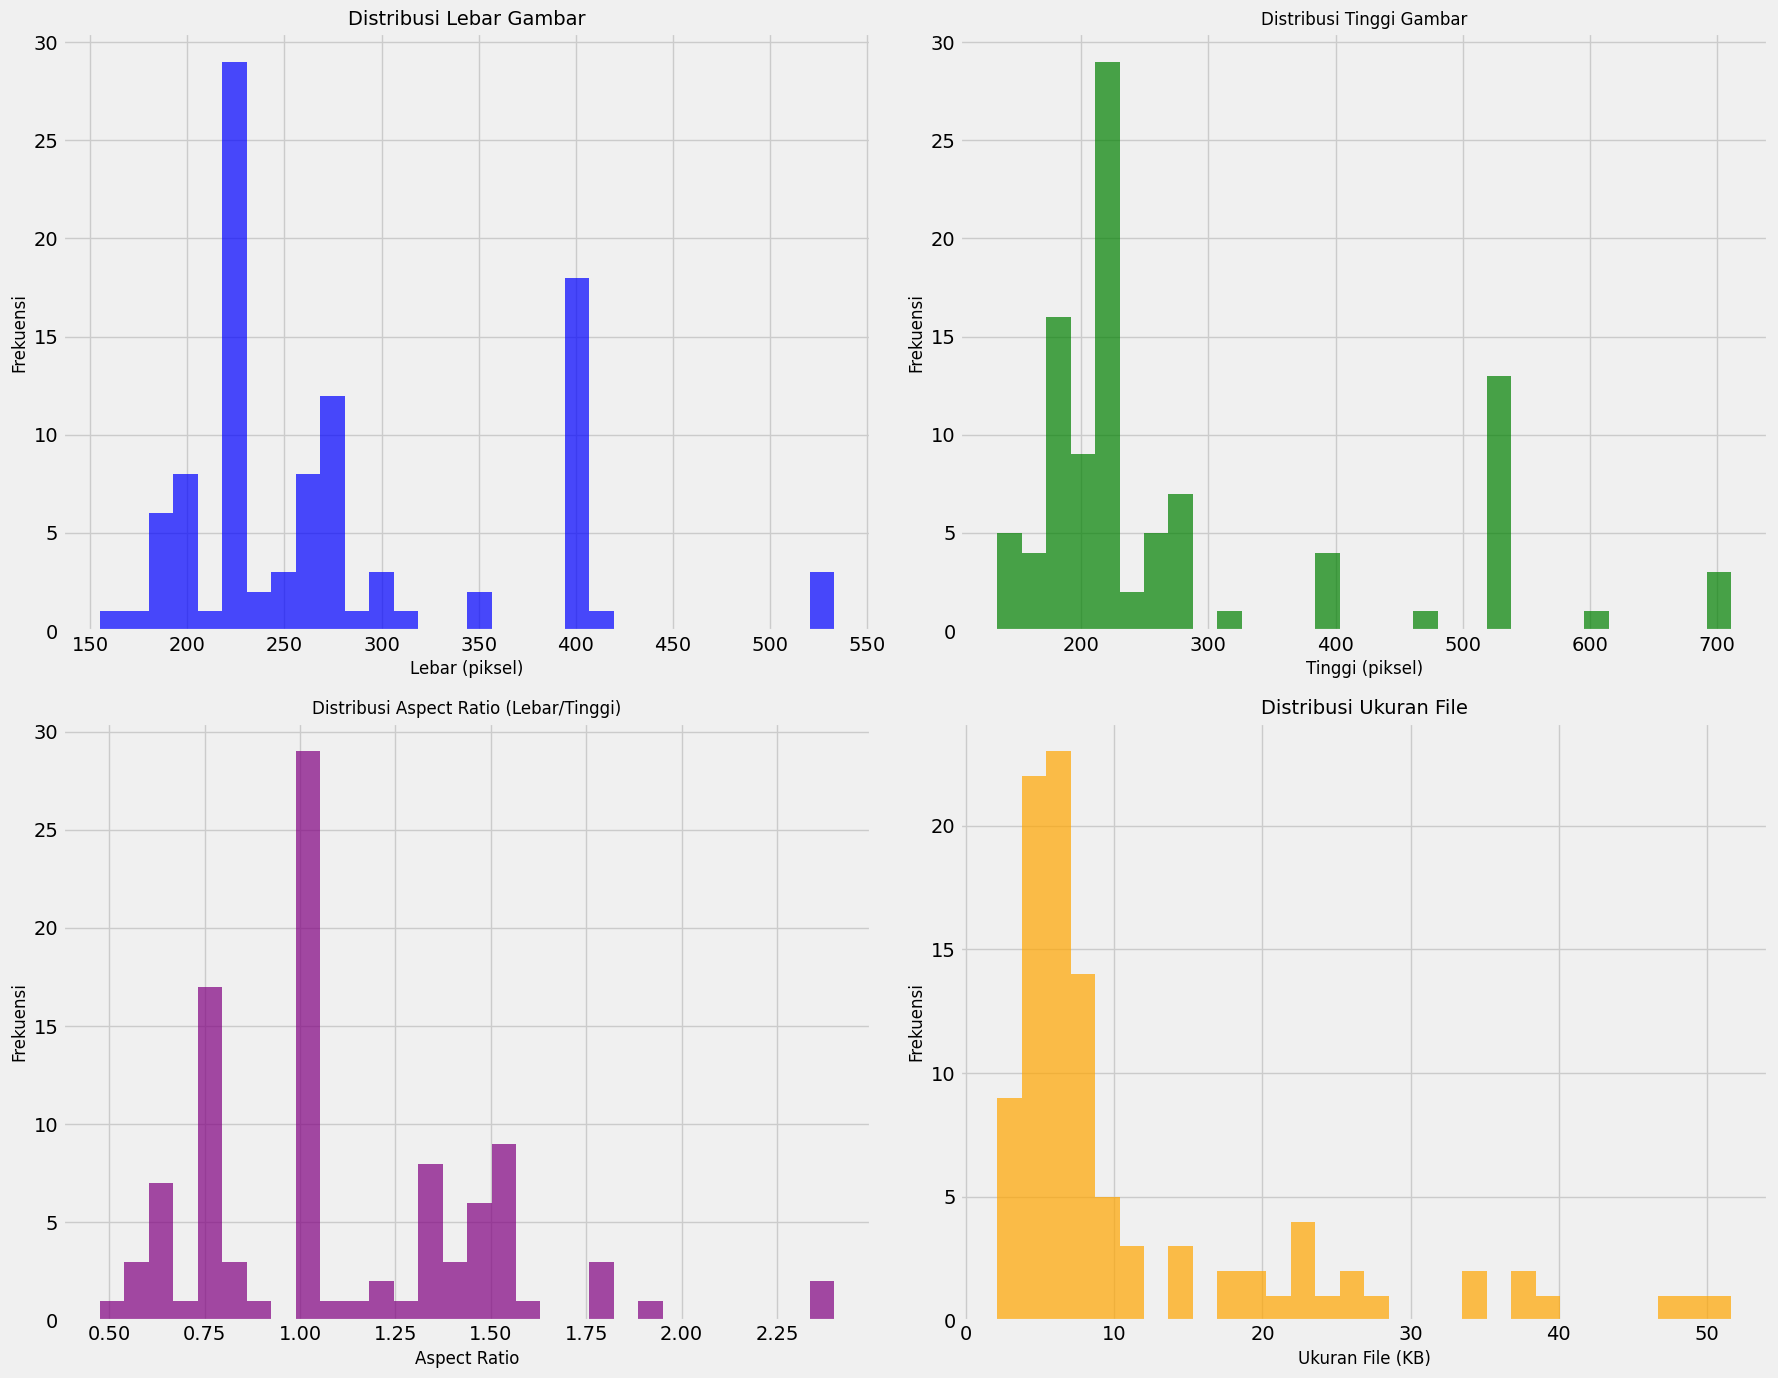

Lebar gambar - Min: 155, Max: 533, Mean: 277.83, Median: 250.5
Tinggi gambar - Min: 134, Max: 711, Mean: 283.70, Median: 225.0
Aspect ration - Min: 0.48, Max: 2.40, Mean: 1.10
Ukuran file (KB) - Min: 2.08, Max: 51.67, Mean: 11.28


In [ ]:
print("Analisis Dimensi Gambar")
widths, heights, aspect_ratios, file_sizes = analyze_image_dimensions(data_dir, classes)



## Analisis Warna Gambar

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt

def analyze_image_colors(base_dir, classes, samples_per_class=5):
    """Menganalisis distribusi warna dalam gambar sampel"""
    color_spaces = ["RGB", "HSV"]
    num_classes = len(classes)

    for cs in color_spaces:
        fig, axes = plt.subplots(num_classes, 3, figsize=(18, 4 * num_classes))
        fig.suptitle(f"Distribusi Nilai {cs} per Kelas", fontsize=16)

        for i, cls in enumerate(classes):
            class_path = os.path.join(base_dir, cls)
            images = os.listdir(class_path)

            # Ambil sampel
            samples = random.sample(images, min(samples_per_class, len(images)))

            # Inisialisasi array untuk menyimpan nilai piksel
            channel_data = [[], [], []]
            if cs == "RGB":
                channel_names = ["Red", "Green", "Blue"]
                colors = ["red", "green", "blue"]
            else:
                channel_names = ["Hue", "Saturation", "Value"]
                colors = ["purple", "magenta", "orange"]

            # Proses setiap sampel gambar
            for img_name in samples:
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)

                if img is None:
                    continue

                if cs == "RGB":
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    for j in range(3):
                        channel_data[j].extend(img[:, :, j].flatten())
                else:
                    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                    for j in range(3):
                        channel_data[j].extend(img_hsv[:, :, j].flatten())

            # Plot histogram untuk setiap channel
            for j in range(3):
                if len(channel_data[j]) > 0:
                    ax = axes[i, j] if num_classes > 1 else axes[j]
                    if cs == "HSV" and j == 0:
                        ax.hist(channel_data[j], bins=30, color=colors[j], alpha=0.7, range=(0, 180))
                    else:
                        ax.hist(channel_data[j], bins=30, color=colors[j], alpha=0.7, range=(0, 255))

                    ax.set_title(f"{cls} - {channel_names[j]}", fontsize=10)
                    ax.set_xlabel("Nilai Piksel", fontsize=8)
                    ax.set_ylabel("Frekuensi", fontsize=8)

        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()


Analisis Warna Gambar


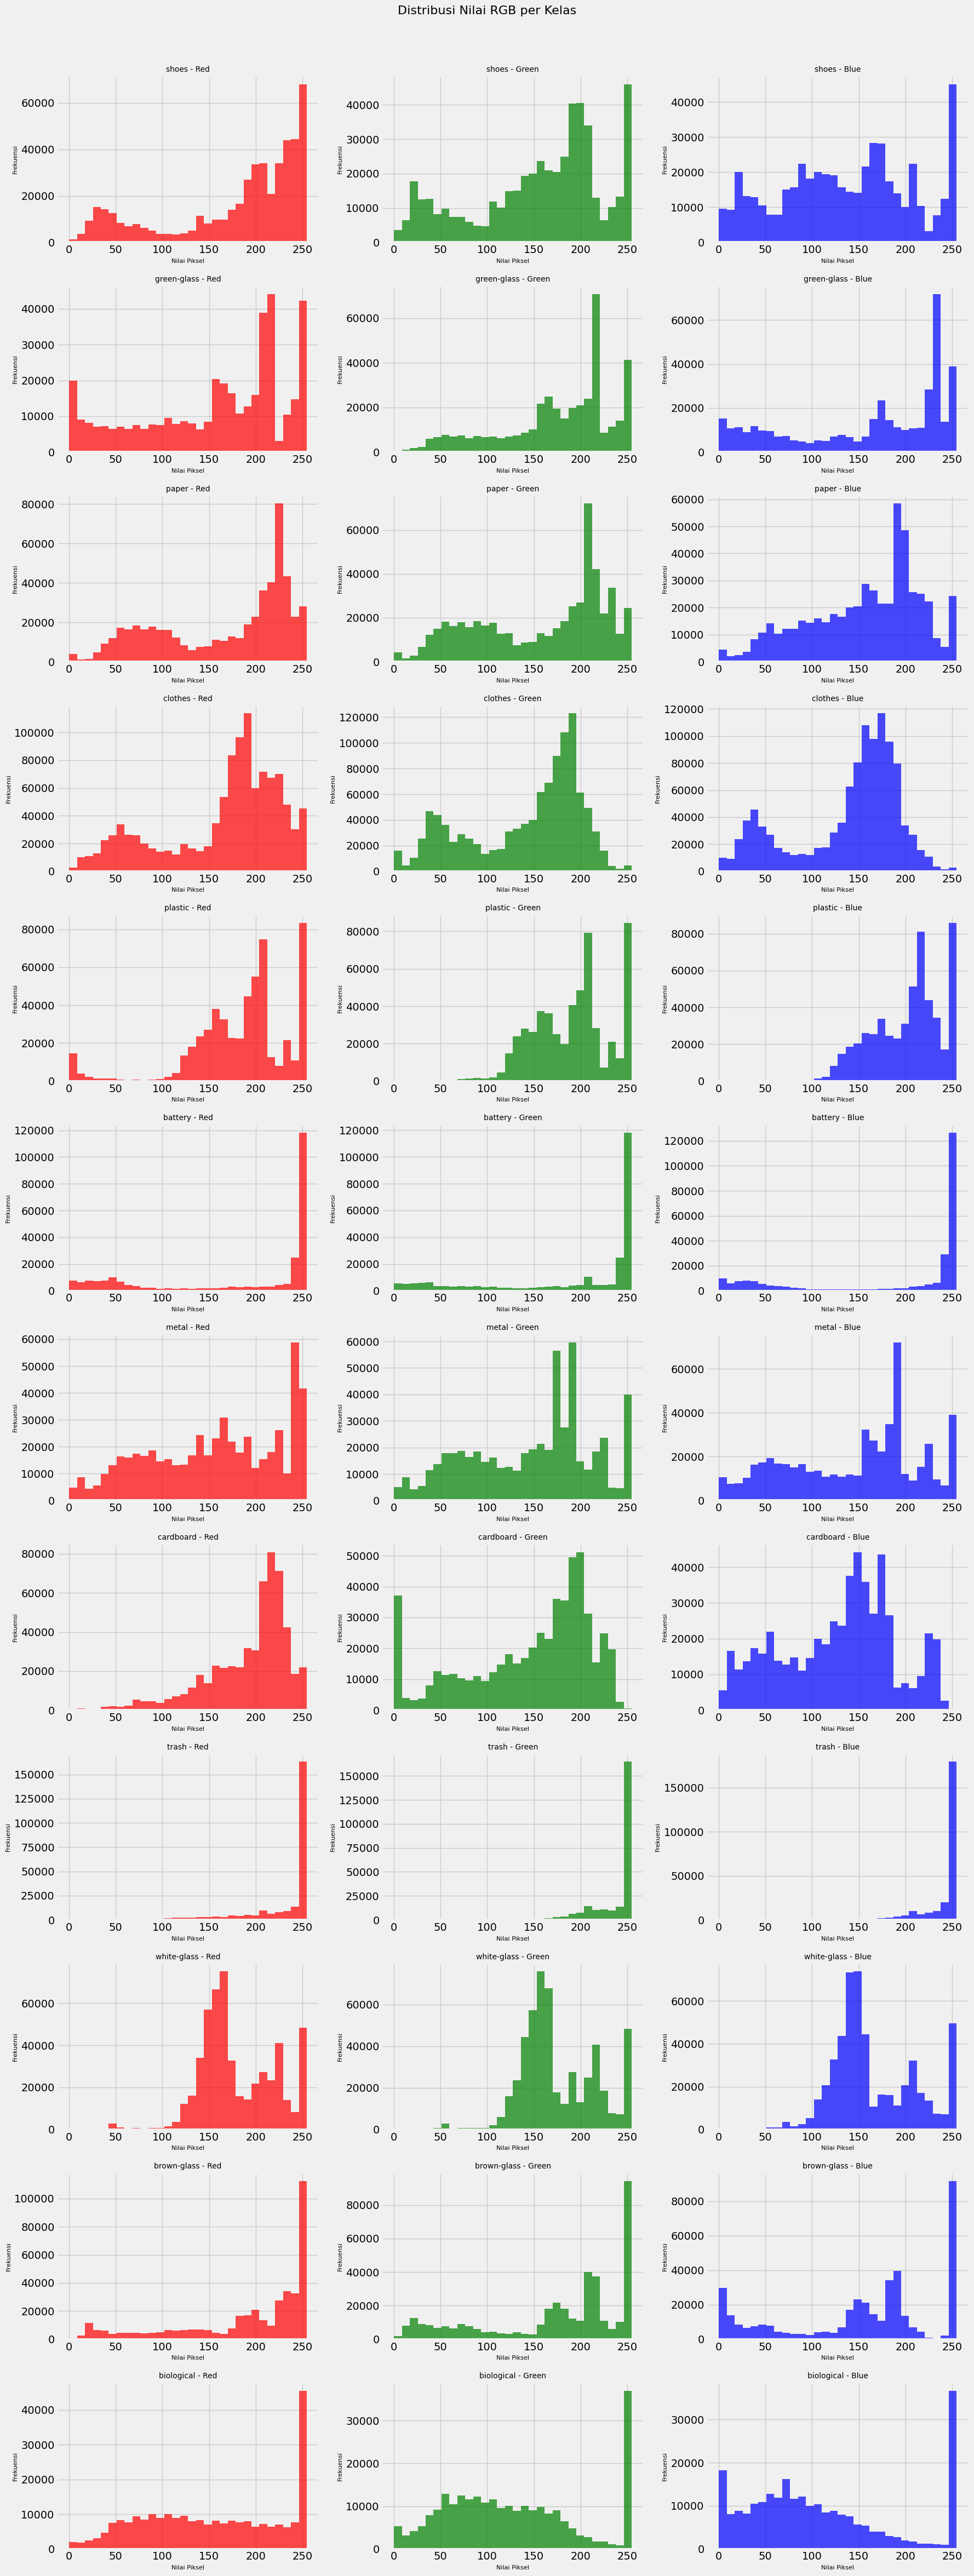

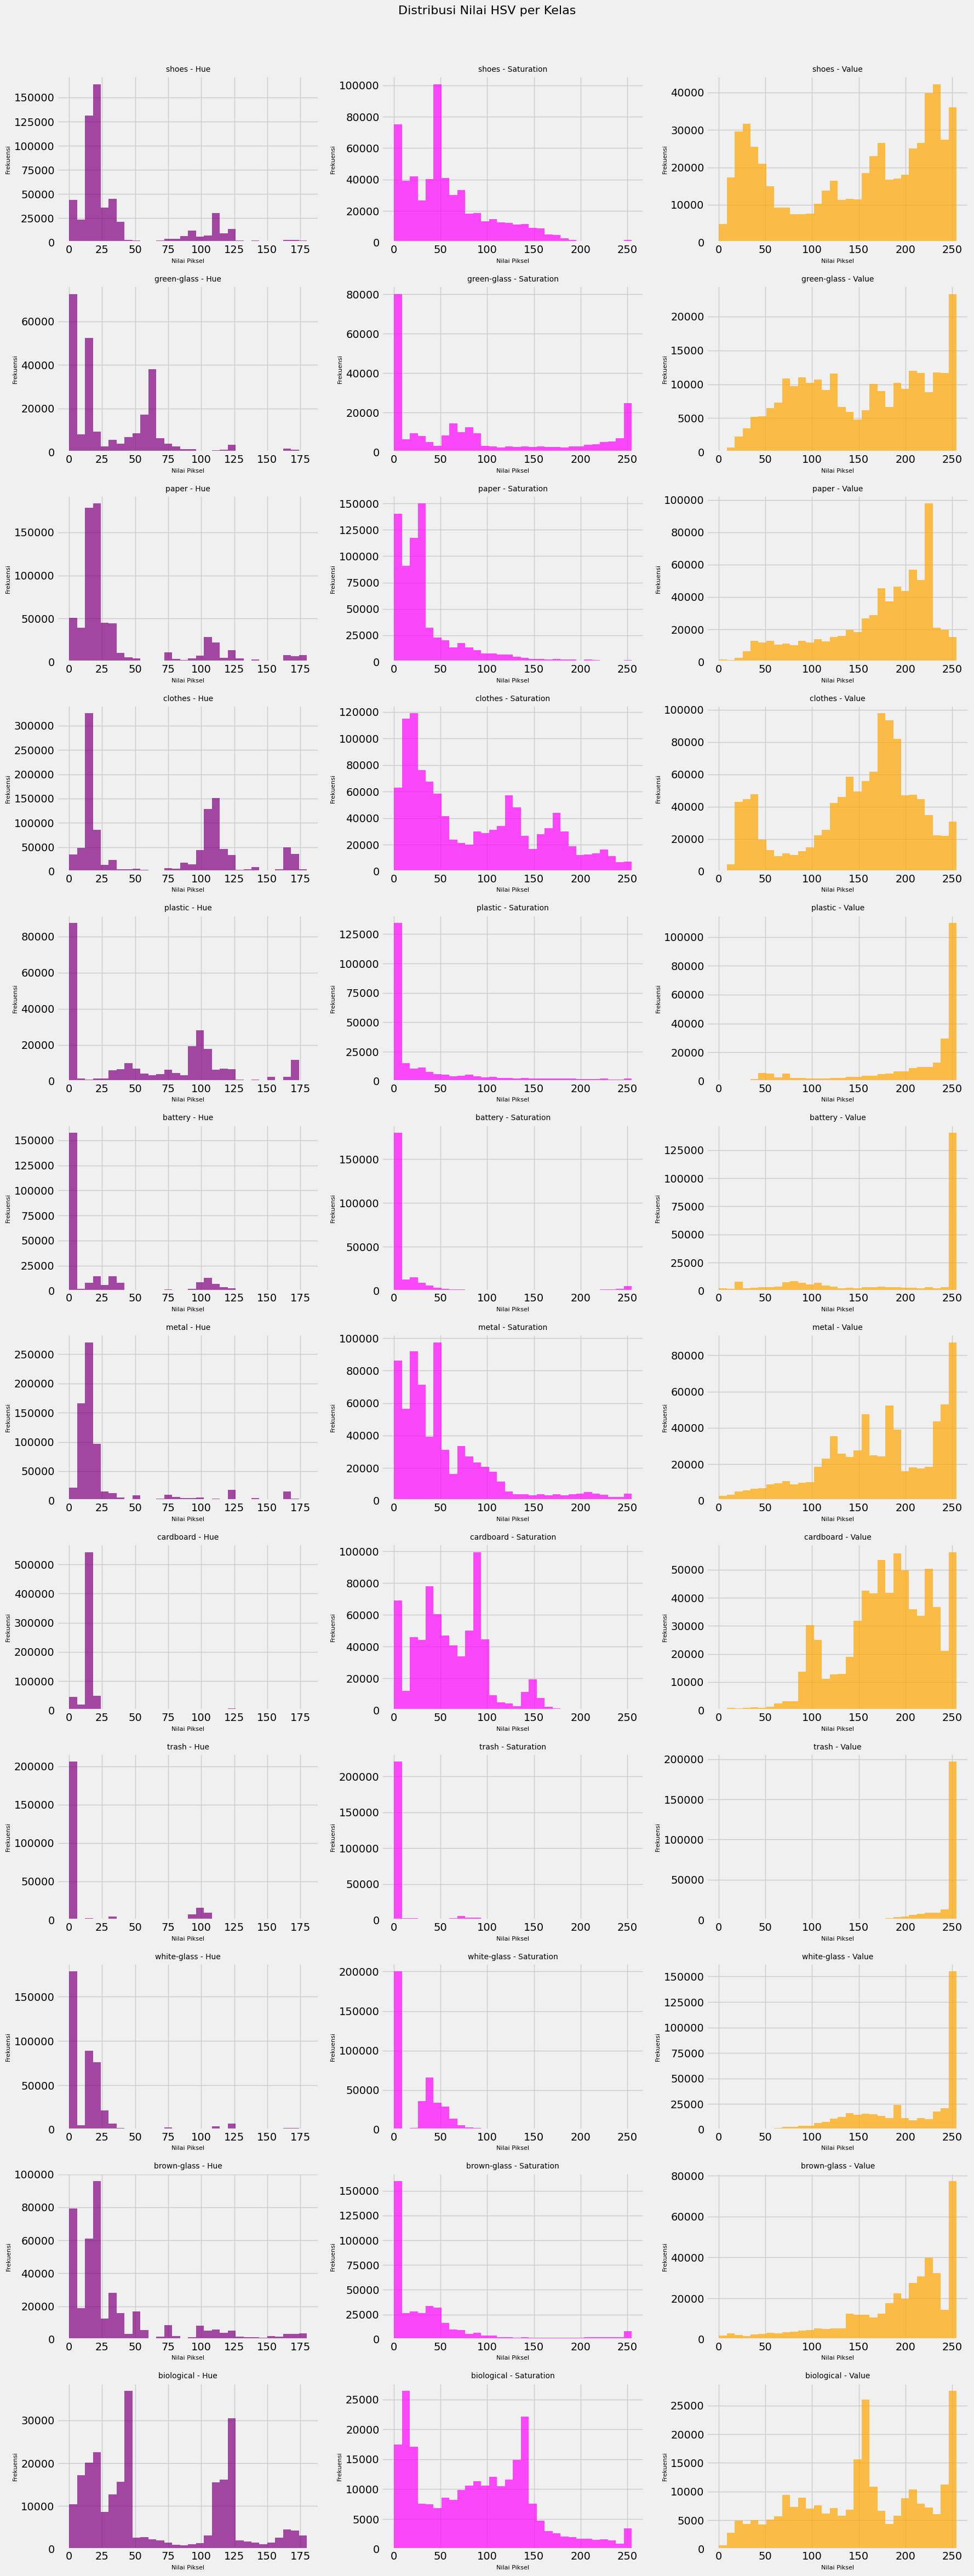

In [ ]:
print("Analisis Warna Gambar")
analyze_image_colors(data_dir, classes)


## Deteksi outliers dalam dimensi gambar

In [ ]:
def detect_dimension_outliers(widths, heights, aspect_ratios):
  """Mendeteksi gambar dengan dimensi yang tidak biasa"""
  # Buat scatterplot lebar vs tinggi
  plt.figure(figsize=(10, 8))
  plt.scatter(widths, heights, alpha=0.5)
  plt.title("Lebar vs Tinggi Gambar", fontsize = 14)
  plt.xlabel("Lebar (piksel)", fontsize = 12)
  plt.ylabel("Tinggi (piksel)", fontsize = 12)
  plt.grid(True, alpha = 0.3)
  plt.show()

  # Outlier berdasarkan IQR untuk aspect ratio
  q1_ar = np.percentile(aspect_ratios, 25)
  q3_ar = np.percentile(aspect_ratios, 75)
  iqr_ar = q3_ar - q1_ar

  lower_bound = q1_ar - 1.5 * iqr_ar
  upper_bound = q3_ar + 1.5 * iqr_ar

  outliers_low = [ar for ar in aspect_ratios if ar < lower_bound]
  outliers_high = [ar for ar in aspect_ratios if ar > upper_bound]

  print(f"Outliers berdasarkan aspect ratio: ")
  print(f"- Di bawah {lower_bound:.2f} : {len(outliers_low)} gambar")
  print(f"- Di atas {upper_bound:.2f} : {len(outliers_high)} gambar")

  # Histogram aspect ratio dengan outlier
  plt.figure(figsize=(12, 6))
  sns.histplot(aspect_ratios, bins=30, kde=True)
  plt.axvline(x=lower_bound, color="red", linestyle="--", label=f"Lower bound: {lower_bound:.2f}")
  plt.axvline(x=upper_bound, color = "red", linestyle="--", label=f"Upper bound: {upper_bound:.2f}")
  plt.title("Distribusi Aspect Ratio dengan Batas Outlier", fontsize = 14)
  plt.xlabel("Aspect Ratio (Lebar/Tinggi)", fontsize = 12)
  plt.ylabel("Frekuensi", fontsize = 12)
  plt.legend()
  plt.show()


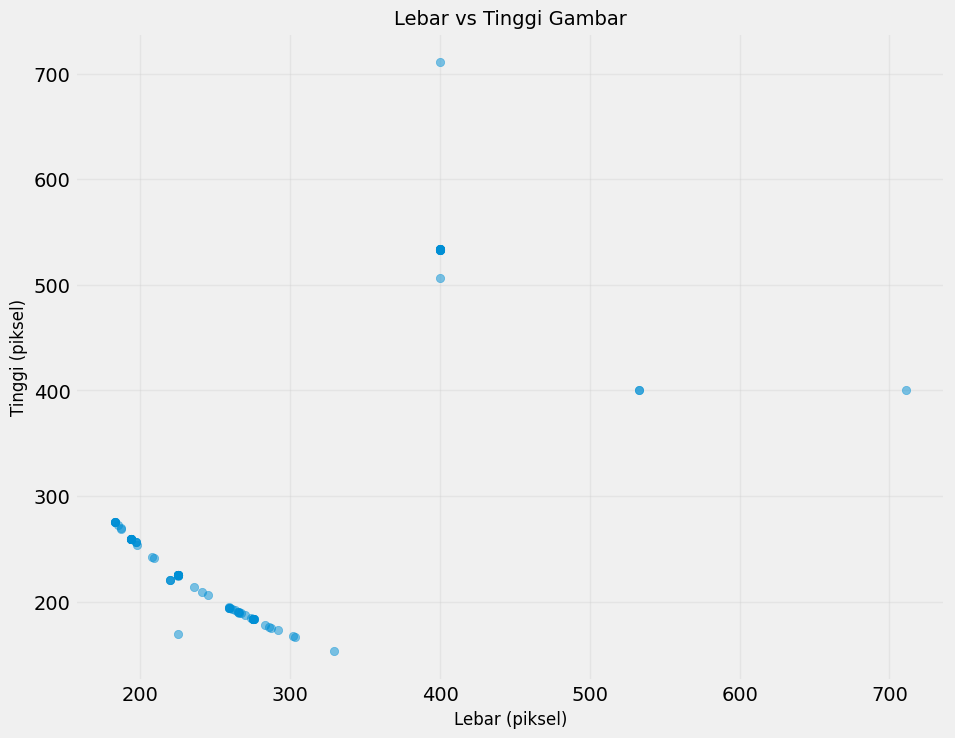

Outliers berdasarkan aspect ratio: 
- Di bawah -0.19 : 0 gambar
- Di atas 2.32 : 0 gambar


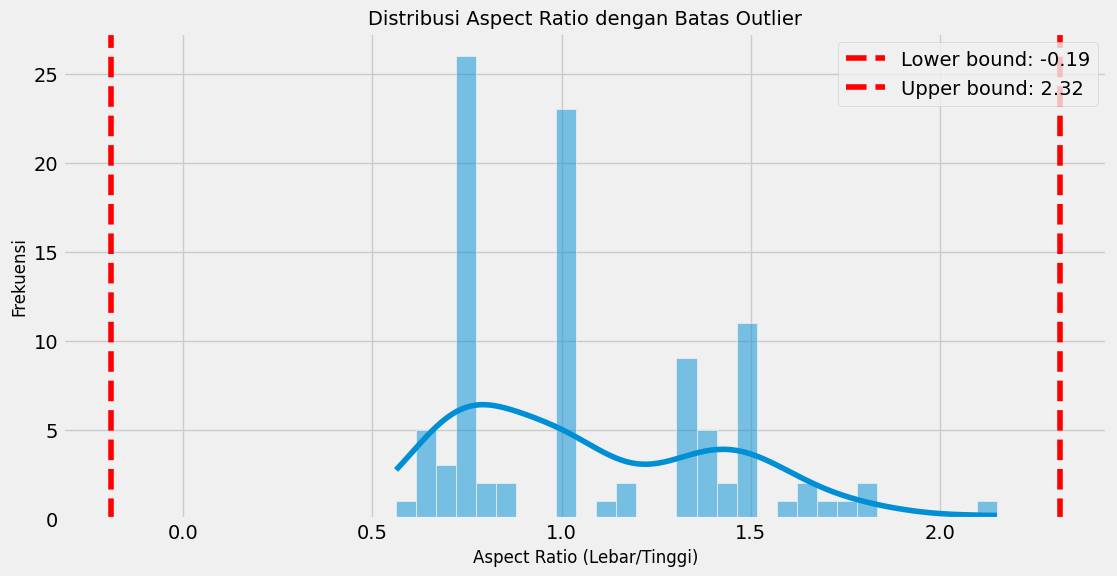

In [ ]:
detect_dimension_outliers(widths, heights, aspect_ratios)

## Analisis Distribusi Ukuran Gambar per Kelas

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import os

def analyze_image_sizes(base_dir, classes):
    """Menganalisis ukuran gambar dari tiap kelas"""
    width_heights = defaultdict(list)

    for cls in classes:
        class_path = os.path.join(base_dir, cls)
        image_files = os.listdir(class_path)

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            try:
                with Image.open(img_path) as img:
                    width, height = img.size
                    width_heights[cls].append((width, height))
            except Exception:
                continue

    # Visualisasi
    fig, axes = plt.subplots(len(classes), 1, figsize=(10, 4 * len(classes)))
    if len(classes) == 1:
        axes = [axes]

    for i, cls in enumerate(classes):
        widths = [wh[0] for wh in width_heights[cls]]
        heights = [wh[1] for wh in width_heights[cls]]

        axes[i].scatter(widths, heights, alpha=0.5)
        axes[i].set_title(f"Distribusi Ukuran Gambar - {cls}")
        axes[i].set_xlabel("Lebar (pixels)")
        axes[i].set_ylabel("Tinggi (pixels)")
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()


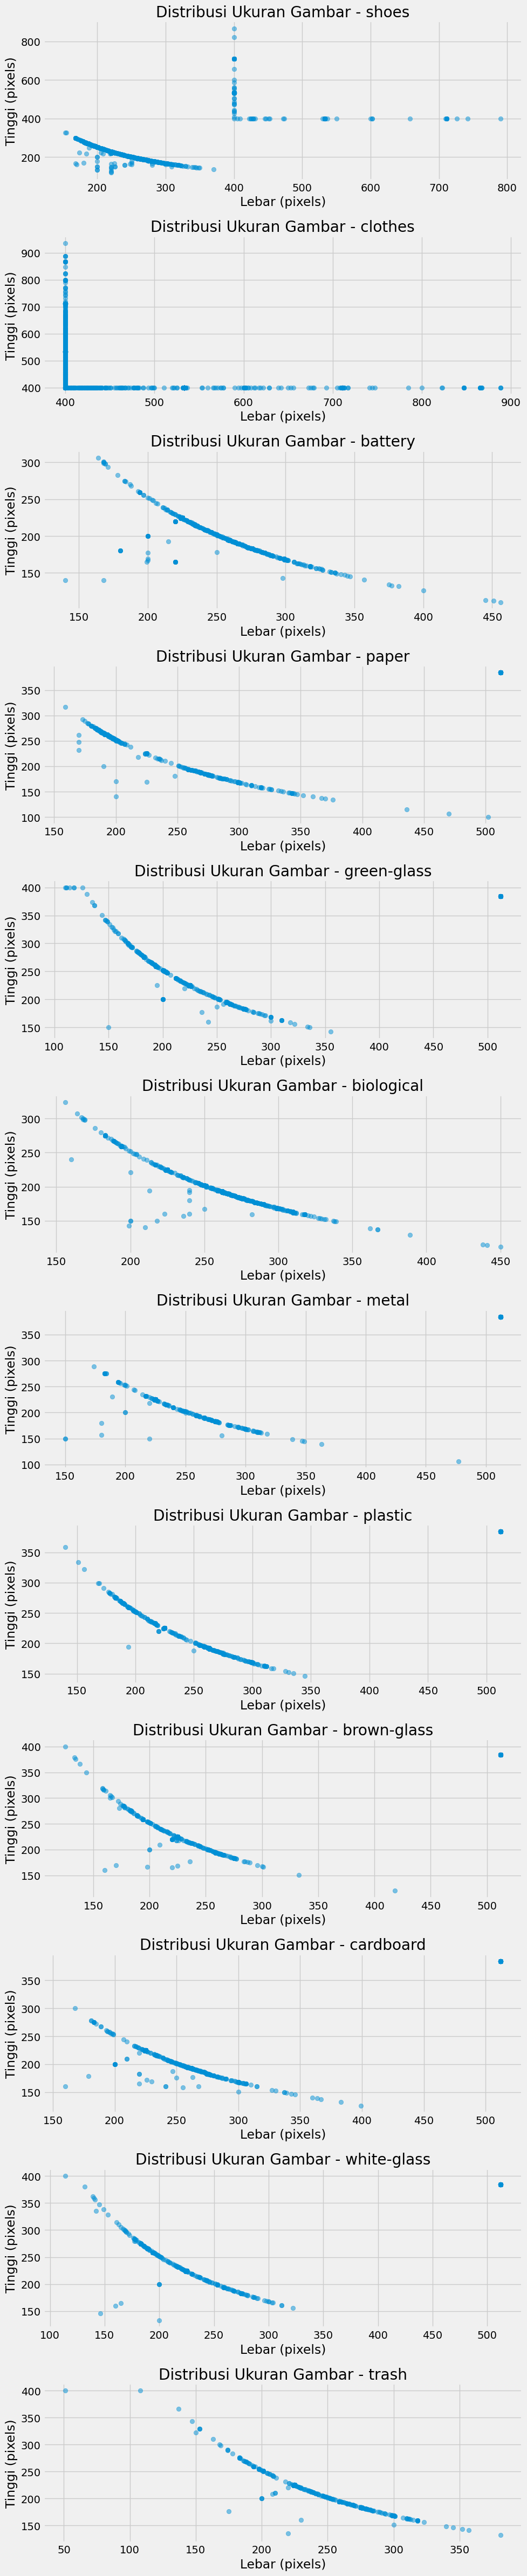

In [ ]:
analyze_image_sizes(data_dir, classes)

## Distribusi Rasio Aspek Gambar
Melihat konsistensi bentuk gambar (misal: kotak, potret,lanskap)
Tujuan: Mengetahui apakah perlu resize atau crop agar model bekerja optimal.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def analyze_aspect_ratios(base_dir, classes):
  """Menganalisis rasio aspek (width/height) gambar per kelas"""
  plt.figure(figsize=(12, 5))

  for cls in classes:
    ratios = []
    class_path = os.path.join(base_dir, cls)
    for cls in os.listdir(class_path):
      try:
        with Image.open(os.path.join(class_path, cls)) as img:
          width, height = img.size
          ratios.append(width/height)
      except:
        continue

    plt.hist(ratios, bins=30, alpha=0.5, label=cls)

  plt.title("Distribusi Rasio Aspek Gambar per Kelas")
  plt.xlabel("Rasio (Lebar / Tinggi)")
  plt.ylabel("Jumlah Gambar")
  plt.legend()
  plt.grid(True)
  plt.show()

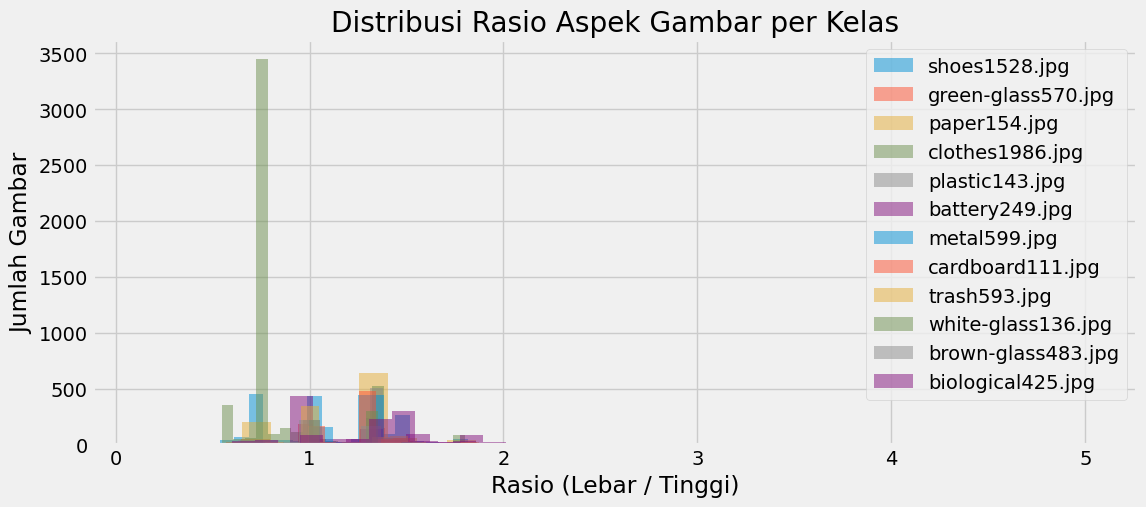

In [ ]:
analyze_aspect_ratios(data_dir, classes)

## Mean Image per Kelas
Menghitung rata-rata visual dari semua gambar dalam satu kelas.
Tujuan: Memberikan inmpresi visual umum dari karakteristik warna dan bentuk di kelas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def plot_mean_images(base_dir, classes, image_size=(128, 128)):
  """Menampilkan rata-rata gambar (mean image) untuk tiap kelas"""
  # fig, axes = plt.subplot(1, len(classes), figsize=(4*len(classes), 4))
  fig, axes = plt.subplots(1, len(classes), figsize=(4*len(classes), 4))
  if len(classes) == 1:
    axes = [axes]

  for i, cls in enumerate(classes):
    class_path = os.path.join(base_dir, cls)
    images = []
    for image_name in os.listdir(class_path):
      img_path = os.path.join(class_path, image_name)
      img = cv2.imread(img_path)
      if img is not None:
        try:
          img = cv2.resize(img, image_size)
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          images.append(img.astype(np.float32))
        except:
          continue

    if images:
      images_np = np.stack(images, axis = 0) # Pastikan semua gambar seragam
      mean_image = np.mean(images_np, axis=0).astype(np.uint8)
      axes[i].imshow(mean_image)
      axes[i].set_title(f"Mean Image: {cls}")
    else:
      axes[i].text(0.5, 0.5, "No valid image", ha="center", va="center")
    axes[i].axis("off")

  plt.tight_layout()
  plt.show()

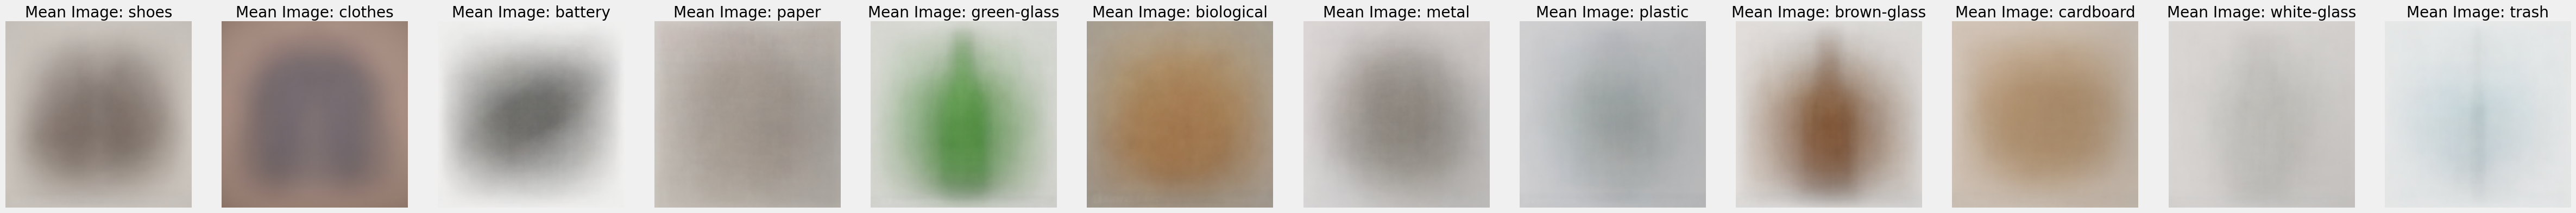

In [ ]:
plot_mean_images(data_dir, classes)

## Warna Dominan per Gambar
Menggunakan KMeans untuk mengambil 3 warna dominan dalam beberapa gambar per kelas.
Tujuan : Menangkap karakteristik warna utama dari gambar secra intuitif

In [ ]:
def show_dominant_colors(base_dir, classes, samples_per_class=3, image_size=(128, 128), num_colors=3):
    """Menampilkan warna dominan dari beberapa gambar per kelas"""
    fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(samples_per_class * 3, len(classes) * 3))
    fig.suptitle("Warna Dominan (Top 3) Per Gambar", fontsize=16)

    for row, cls in enumerate(classes):
        class_path = os.path.join(base_dir, cls)
        images = os.listdir(class_path)
        samples = random.sample(images, min(samples_per_class, len(images)))

        for col, fname in enumerate(samples):
            img_path = os.path.join(class_path, fname)
            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, image_size)
            img_flat = img.reshape((-1, 3))

            kmeans = KMeans(n_clusters=num_colors, random_state=42)
            kmeans.fit(img_flat)

            colors = kmeans.cluster_centers_.astype(int)
            proportions = np.bincount(kmeans.labels_)
            sorted_idx = np.argsort(-proportions)

            color_palette = np.zeros((50, 300, 3), dtype=int)
            start_x = 0
            for i in sorted_idx:
                width = int(300 * proportions[i] / np.sum(proportions))
                color_palette[:, start_x:start_x+width, :] = colors[i]
                start_x += width

            axes[row, col].imshow(color_palette.astype(np.uint8))
            axes[row, col].axis("off")
            axes[row, col].set_title(f"Img: {fname}", fontsize=8)

        # Tambahkan nama kelas di samping kiri baris
        axes[row, 0].set_ylabel(cls, fontsize=10, rotation=0, labelpad=50, va='center')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


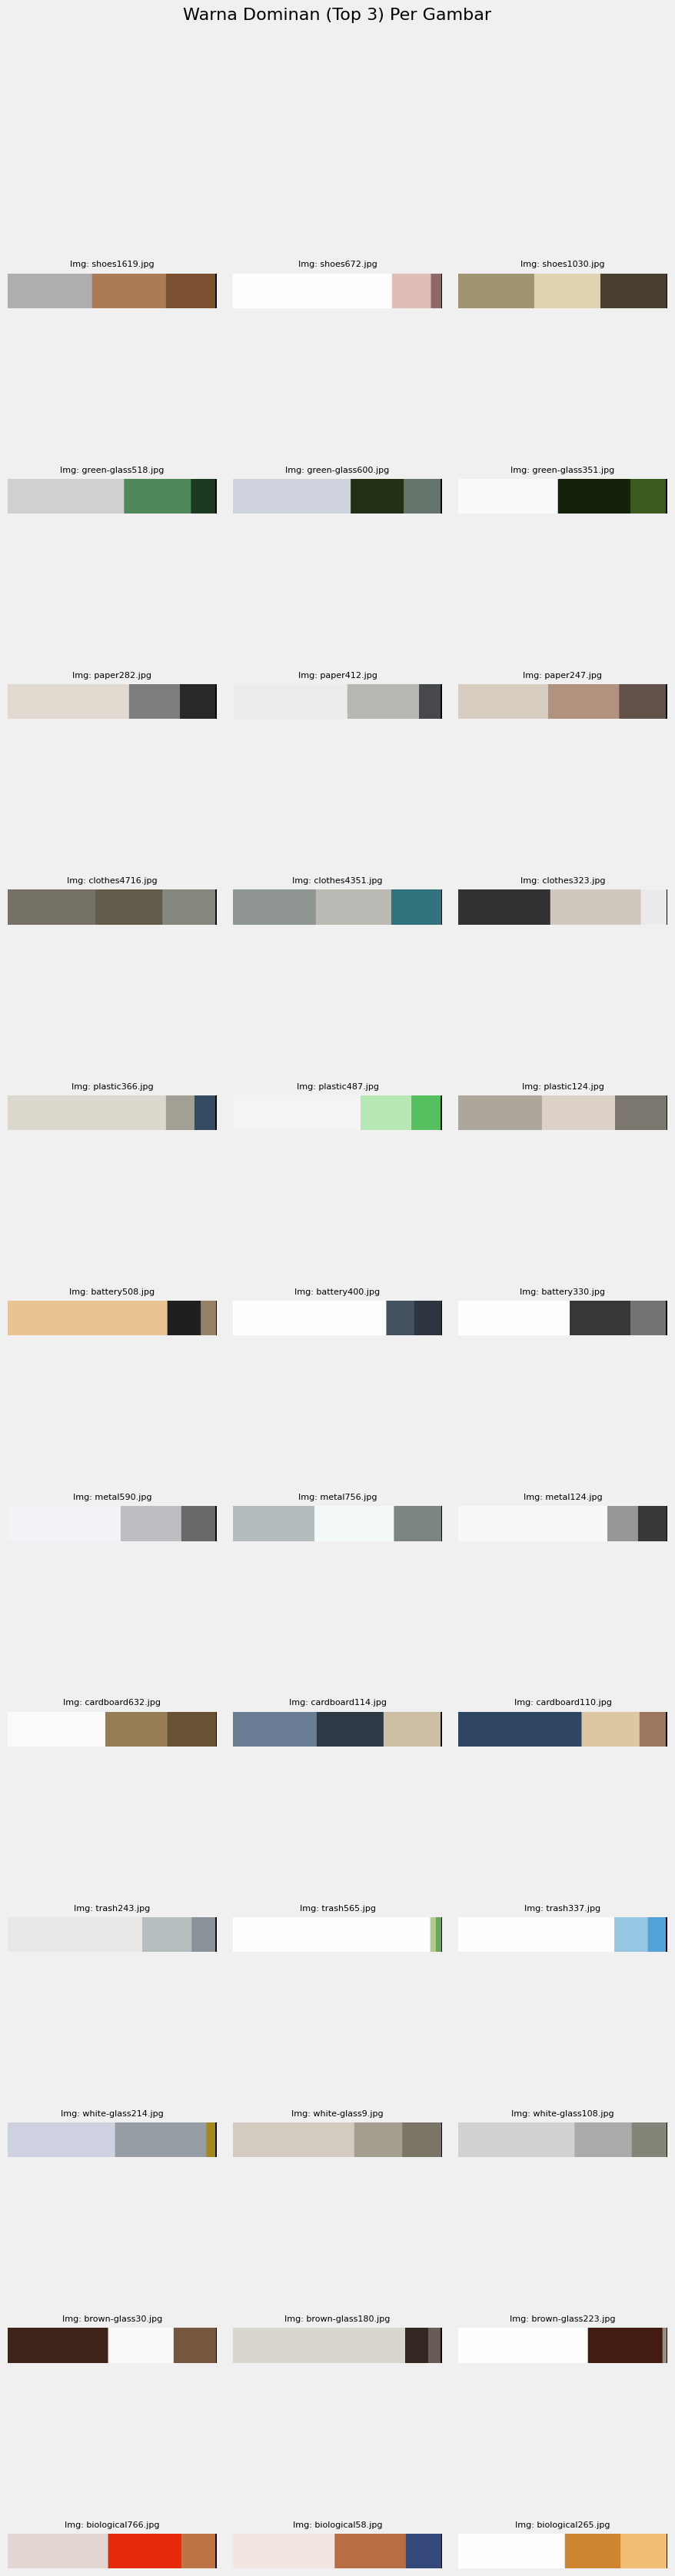

In [ ]:
show_dominant_colors(data_dir, classes)

## Fungsi utama menjalankan EDA

In [ ]:
def run_garbage_classification_eda(data_dir):
  """Menjalankan keseluruhan proses EDA"""
  print("====== EXPLORATORY DATA ANALYSIS: GARBAGE CLASSIFICATION DATASET ======")
  print("\n1. Eksplorasi Struktur Dataset")
  classes, class_counts, total_images = explore_dataset_structure(data_dir)

  print("\n2. Visualisasi Distribusi Kelas")
  plot_class_distribution(class_counts)

  print("\n3.Visualisasi Sampel Gambar")
  display_sample_images(data_dir, classes)

  print("\n4. Analisis Dimensi Gambar")
  widths, heights, aspect_ratios, file_sizes = analyze_image_dimensions(data_dir, classes)

  print("\n5. Deteksi Outliers dalam Dimensi Gambar")
  detect_dimension_outliers(widths, heights, aspect_ratios)

  print("\n6. Analisis Warna Gambar")
  analyze_image_colors(data_dir, classes)

  print("\n=====KESIMPULAN EDA=====")
  print(f"- Dataset terdiri dari {len(classes)} kelas dengan total {total_images} gambar")
  if max(class_counts.values()) / min(class_counts.values()) > 1.5:
      print("- Terdapat ketidakseimbangan kelas yang perlu diperhatikan")
  print(f"- Rentang dimensi gambar bervariasi dari ({min(widths)}x{min(heights)}) hingga ({max(widths)}x{max(heights)}) piksel")
  print("- Diperlukan preprocessing gambar untuk menyeragamkan dimensi sebelum melatih model CNN")
  print("- Berdasarkan analisis warna, terdapat perbedaan pola distribusi warna antar kelas yang dapat membantu klasifikasi")



====== EXPLORATORY DATA ANALYSIS: GARBAGE CLASSIFICATION DATASET ======

1. Eksplorasi Struktur Dataset
Struktur Dataset: 
Jumlah kelas: 12
Nama kelas: 
 - shoes : 1977 gambar
 - clothes : 5325 gambar
 - battery : 945 gambar
 - paper : 1050 gambar
 - green-glass : 629 gambar
 - biological : 985 gambar
 - metal : 769 gambar
 - plastic : 865 gambar
 - brown-glass : 607 gambar
 - cardboard : 891 gambar
 - white-glass : 775 gambar
 - trash : 697 gambar
Total gambar: 15515

2. Visualisasi Distribusi Kelas


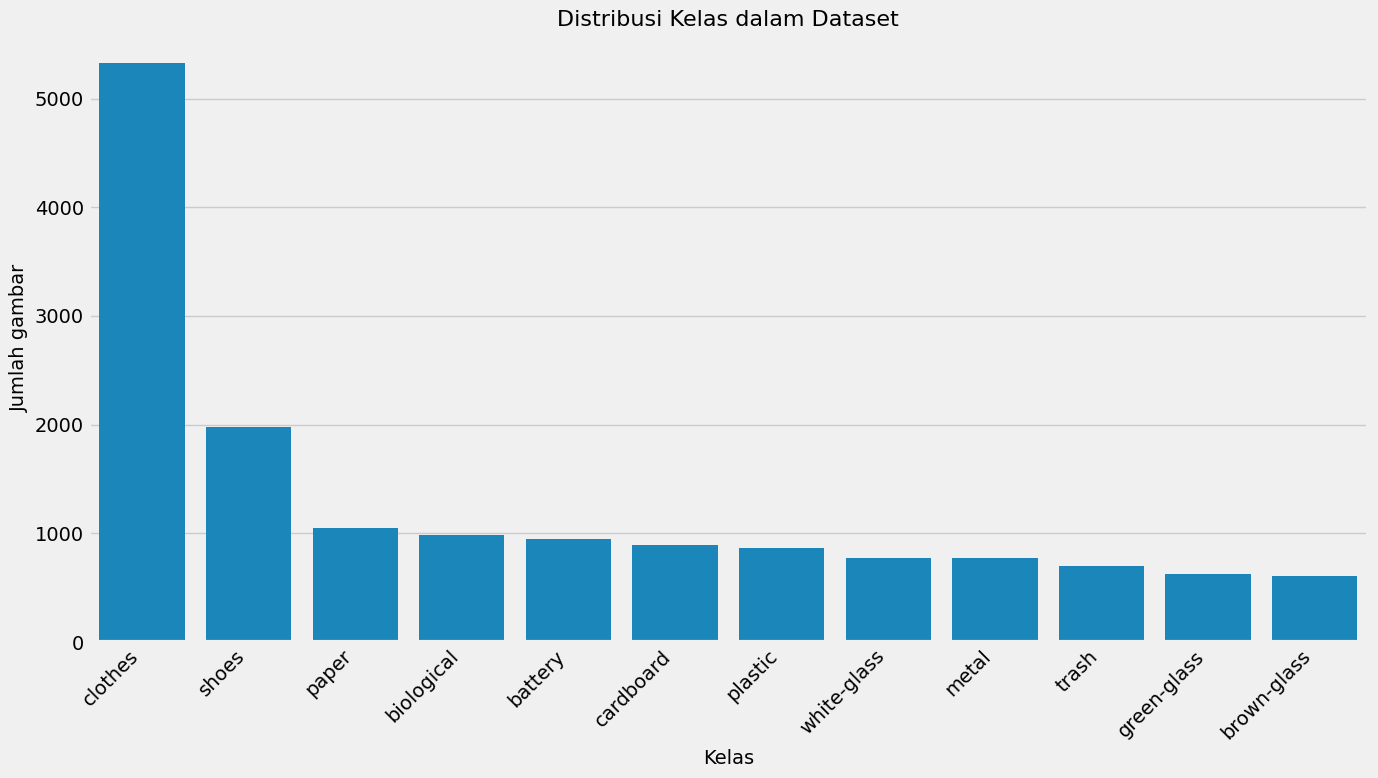

Persentase setiap kelas:
clothes: 34.32%
shoes: 12.74%
paper: 6.77%
biological: 6.35%
battery: 6.09%
cardboard: 5.74%
plastic: 5.58%
white-glass: 5.00%
metal: 4.96%
trash: 4.49%
green-glass: 4.05%
brown-glass: 3.91%

3.Visualisasi Sampel Gambar


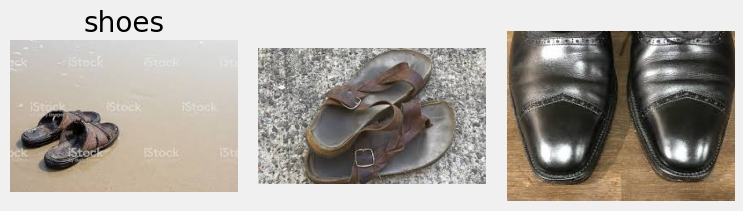

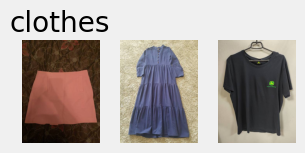

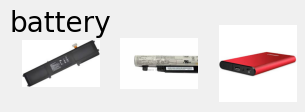

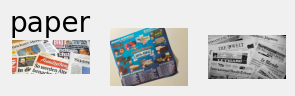

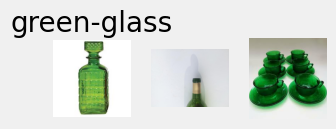

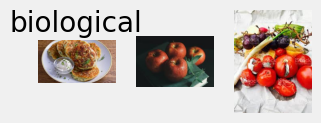

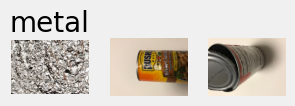

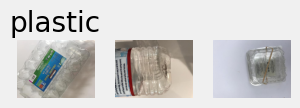

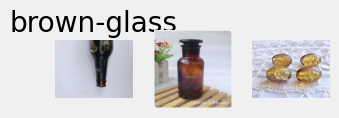

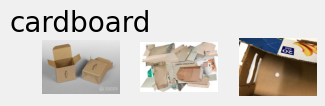

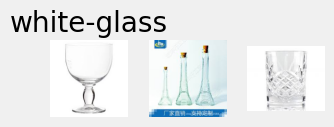

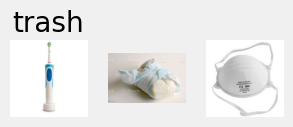


4. Analisis Dimensi Gambar


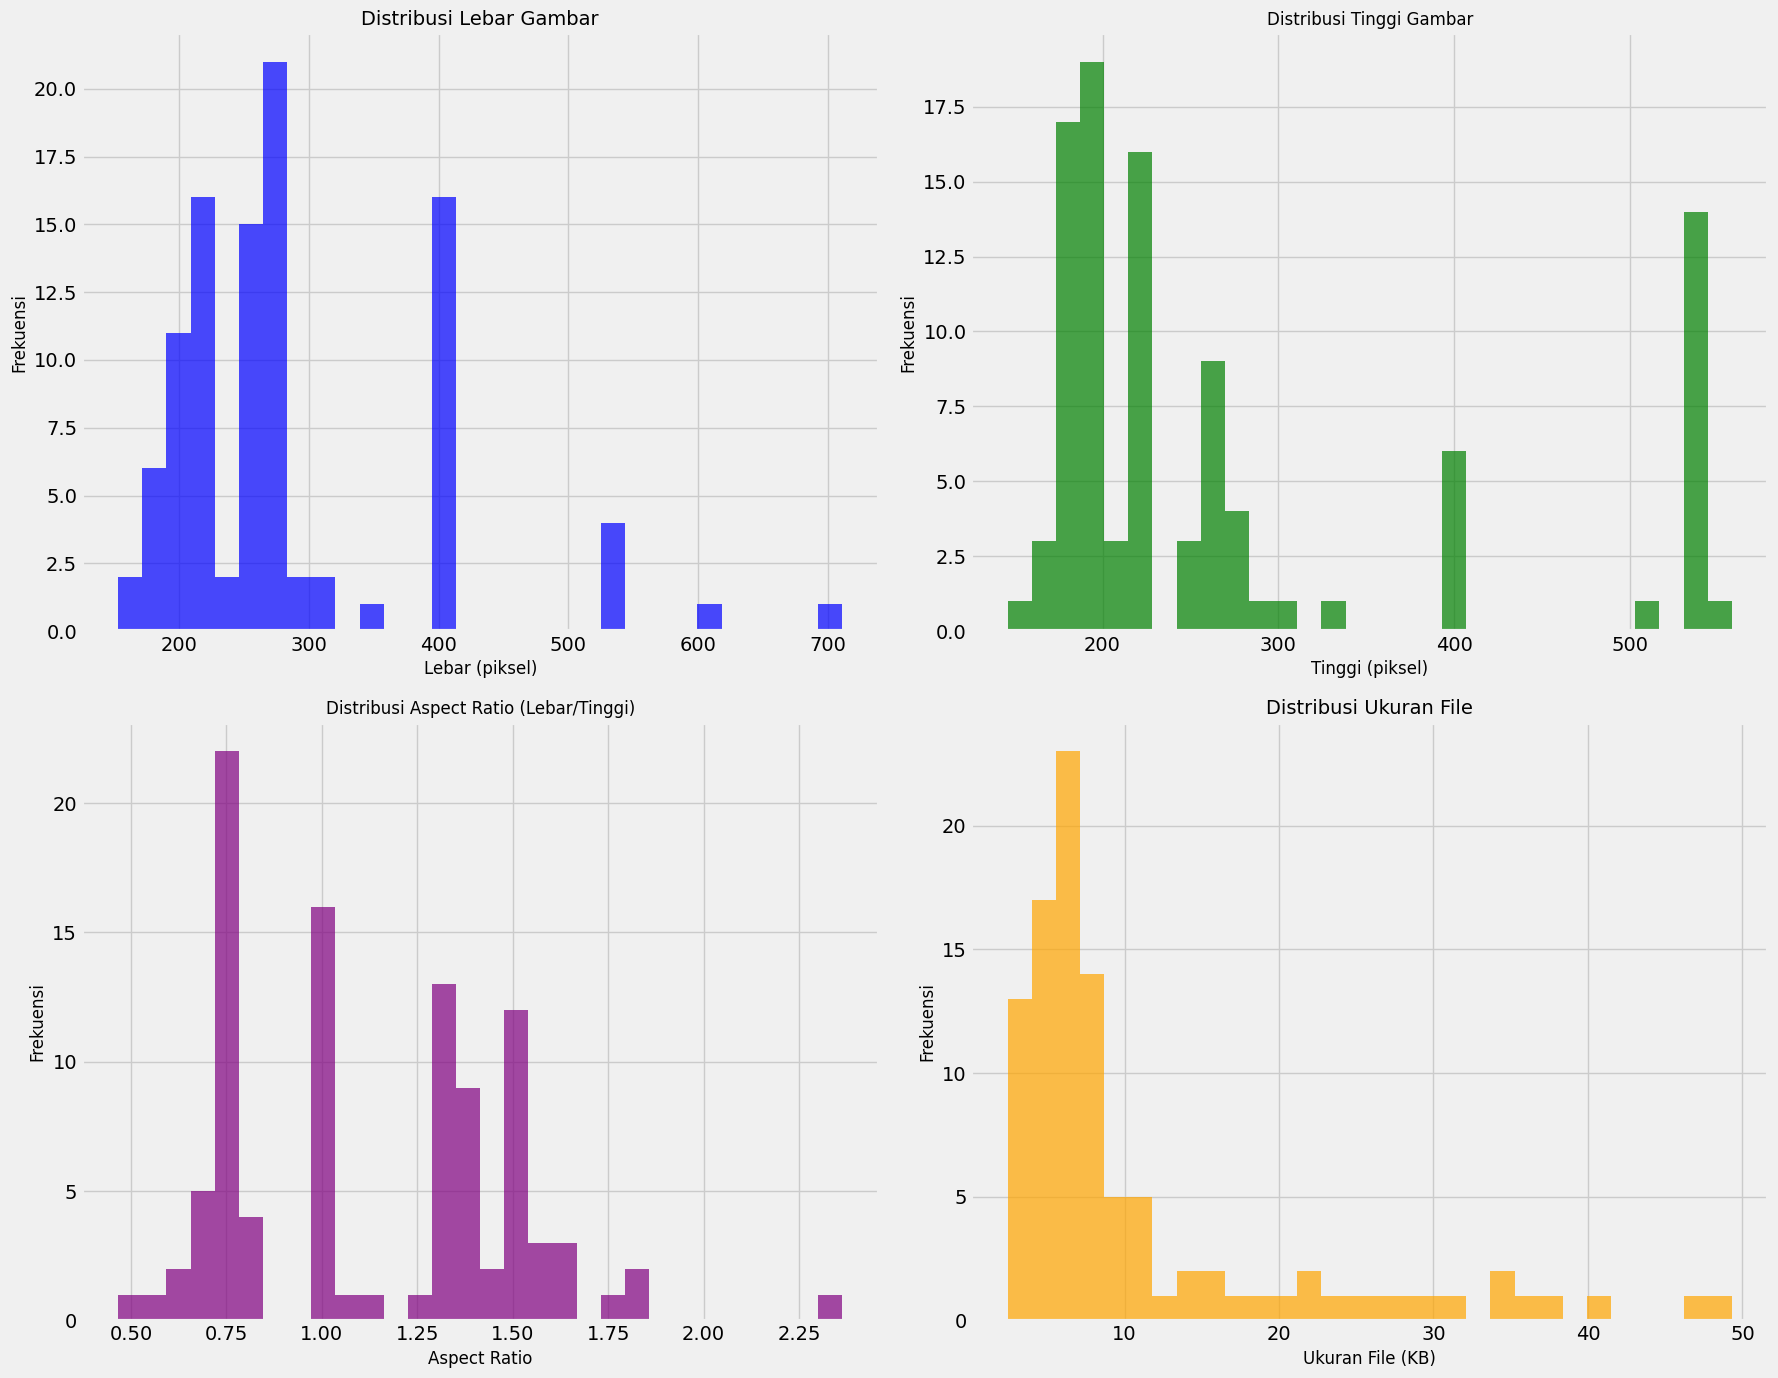

Lebar gambar - Min: 153, Max: 711, Mean: 286.72, Median: 263.5
Tinggi gambar - Min: 146, Max: 558, Mean: 276.48, Median: 225.0
Aspect ration - Min: 0.47, Max: 2.36, Mean: 1.13
Ukuran file (KB) - Min: 2.43, Max: 49.31, Mean: 10.94

5. Deteksi Outliers dalam Dimensi Gambar


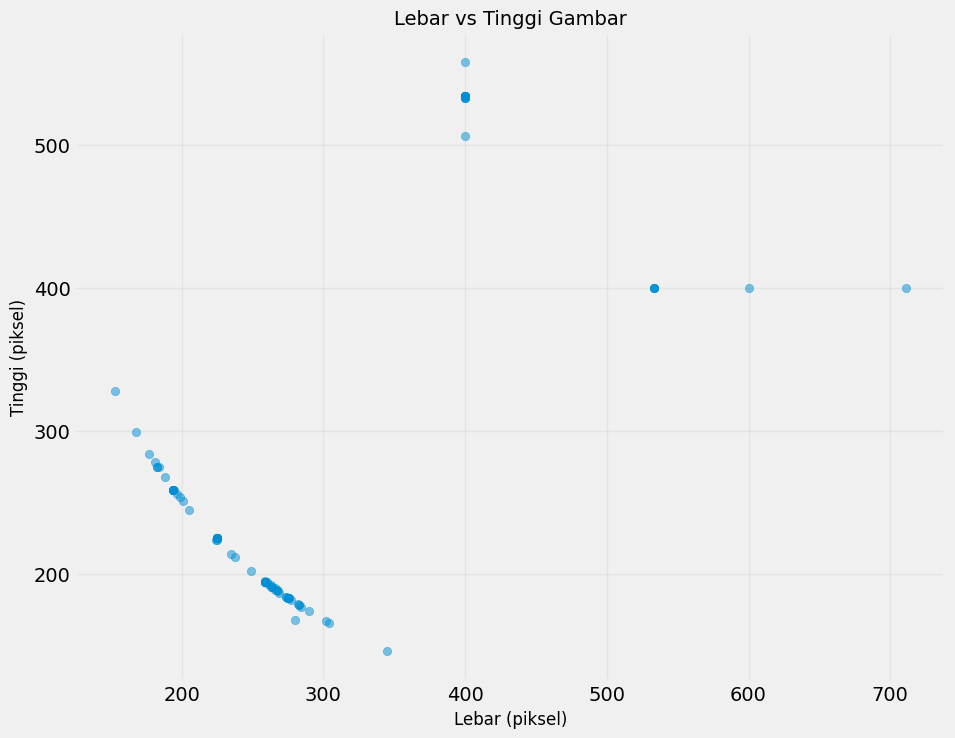

Outliers berdasarkan aspect ratio: 
- Di bawah -0.25 : 0 gambar
- Di atas 2.41 : 0 gambar


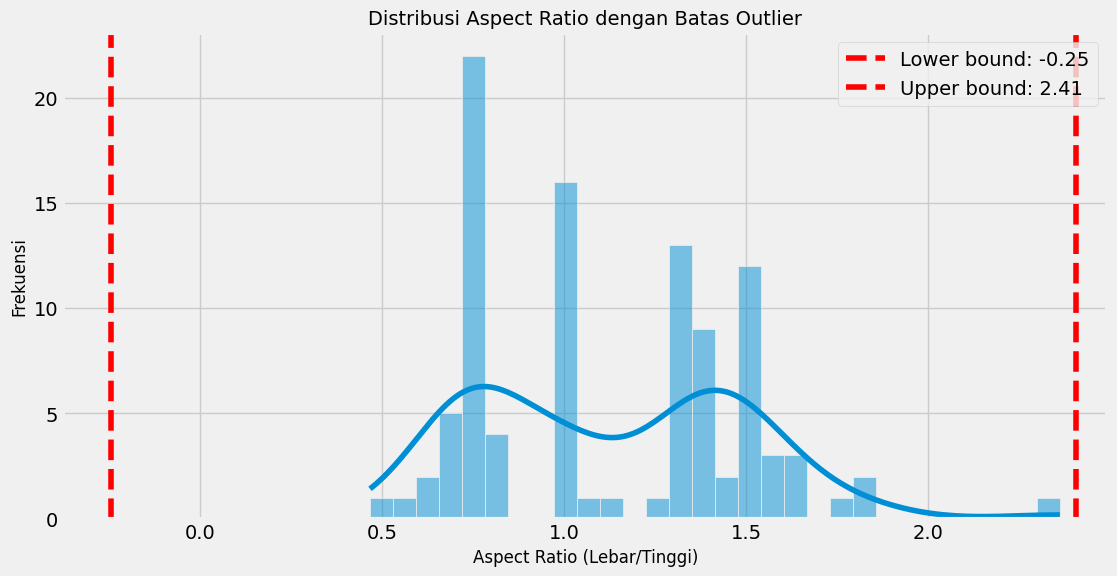


6. Analisis Warna Gambar


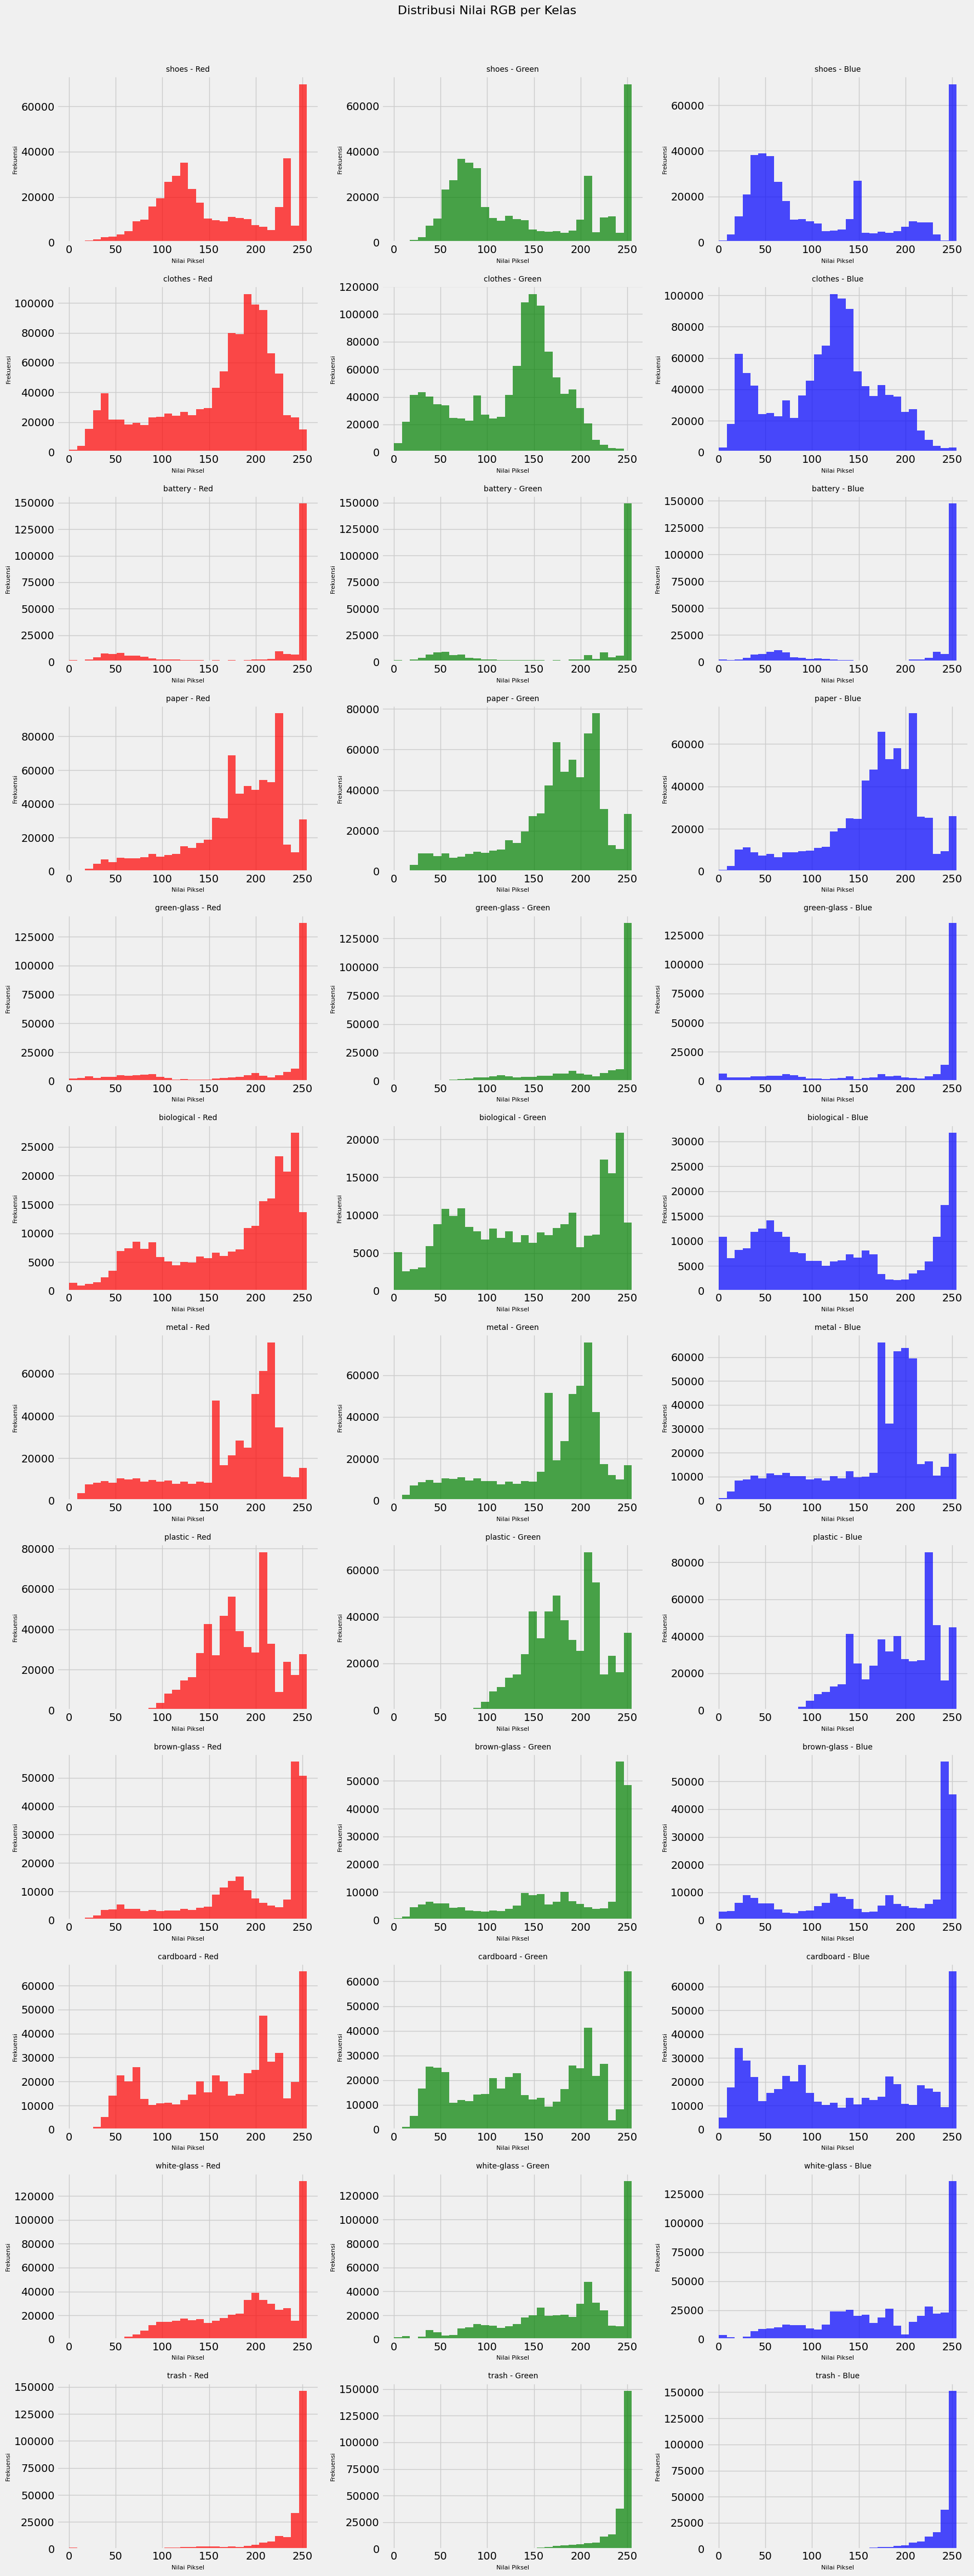

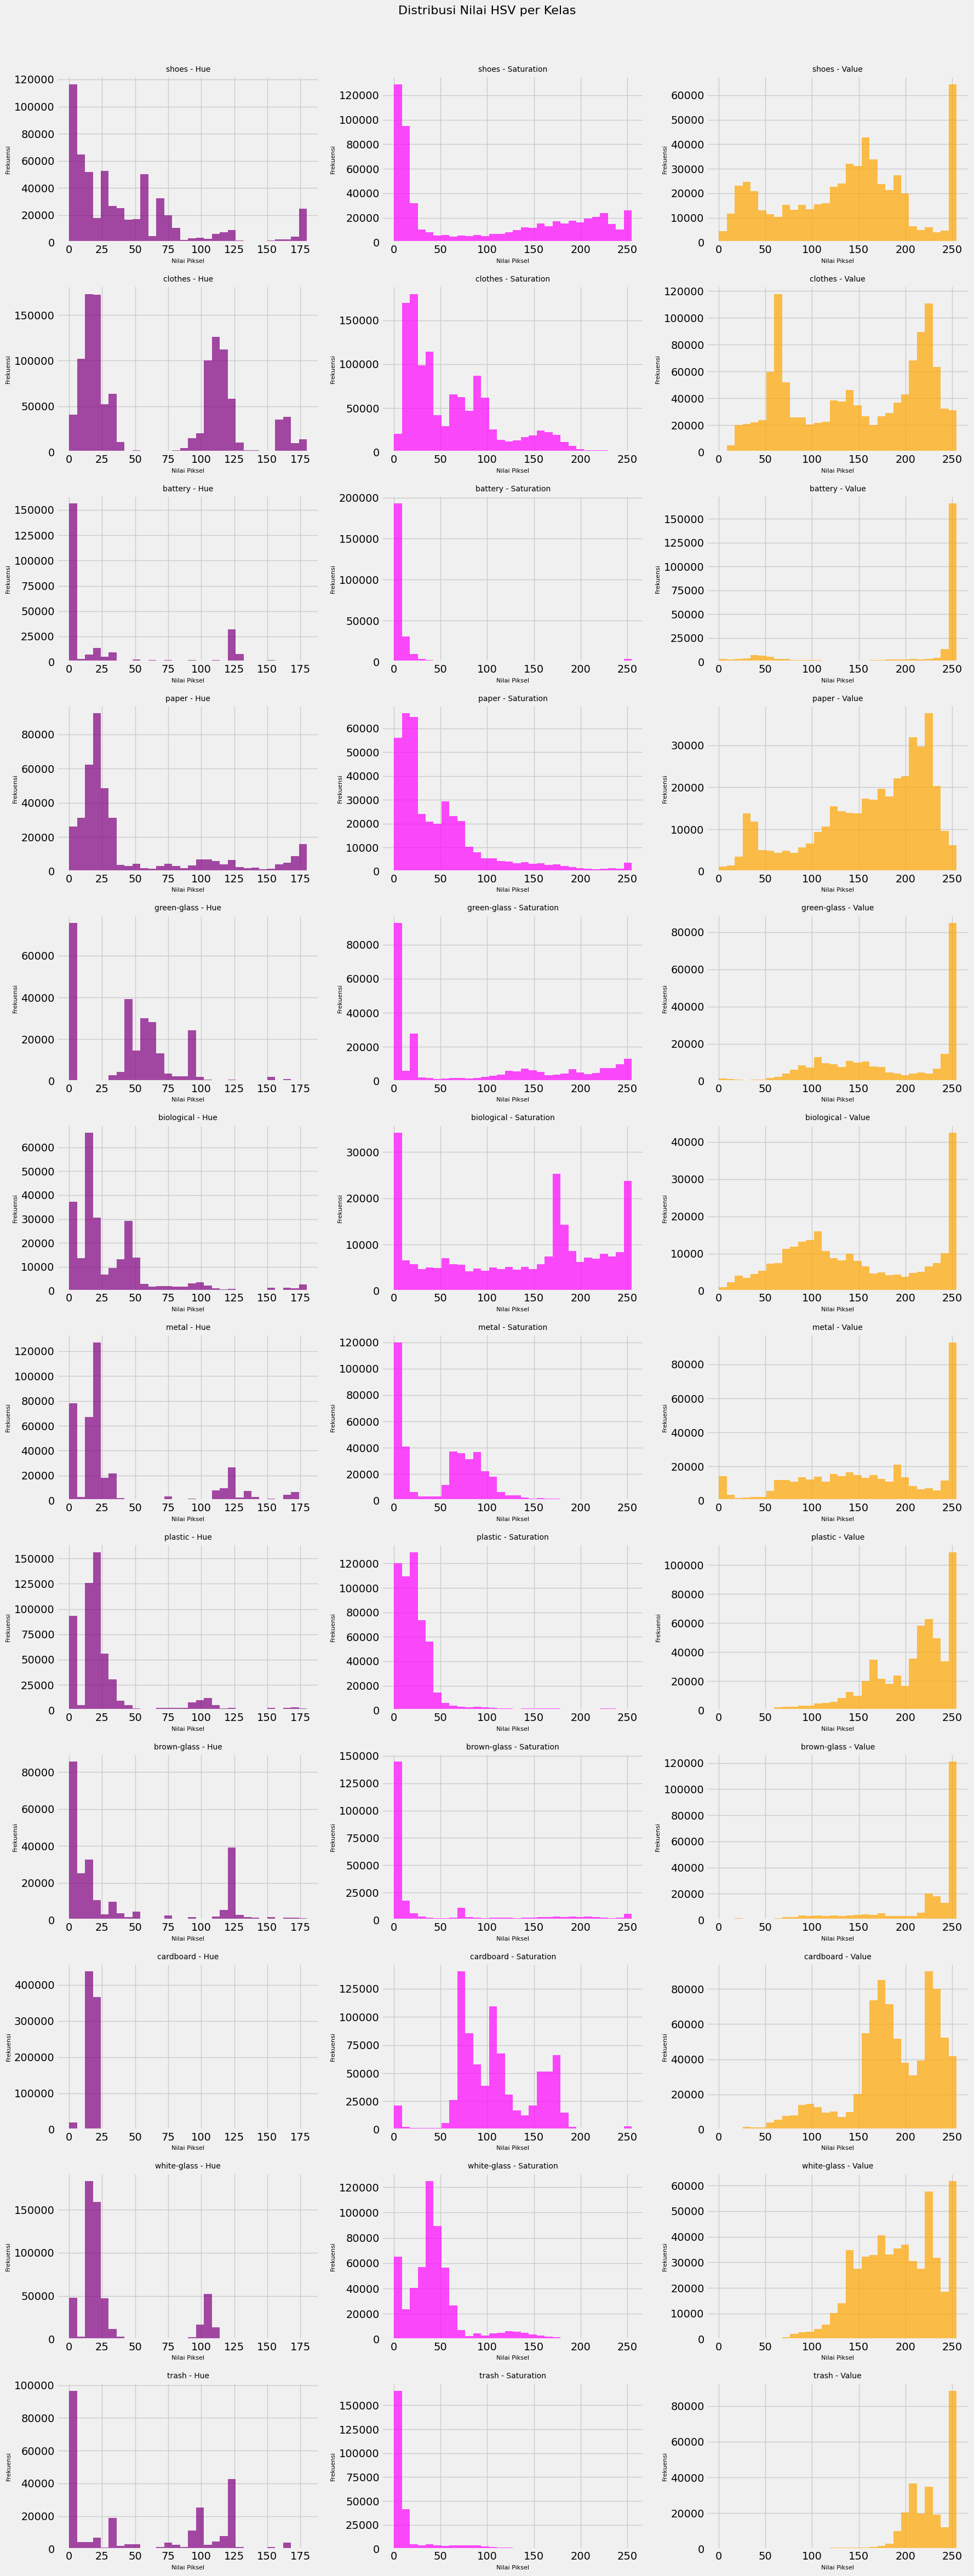


=====KESIMPULAN EDA=====
- Dataset terdiri dari 12 kelas dengan total 15515 gambar
- Terdapat ketidakseimbangan kelas yang perlu diperhatikan
- Rentang dimensi gambar bervariasi dari (153x146) hingga (711x558) piksel
- Diperlukan preprocessing gambar untuk menyeragamkan dimensi sebelum melatih model CNN
- Berdasarkan analisis warna, terdapat perbedaan pola distribusi warna antar kelas yang dapat membantu klasifikasi


In [ ]:
try:
    run_garbage_classification_eda(data_dir)
except FileNotFoundError:
    print(f"ERROR: Folder '{data_dir}' tidak ditemukan. Silakan sesuaikan jalur ke dataset yang telah didownload dan diekstrak.")
    print("Catatan: Struktur folder yang diharapkan adalah folder utama yang berisi subfolder untuk setiap kelas.")